# Housing price prediction

- Author: Jay Shah [@jayshah5696](https://github.com/jayshah5696)
- Date: 03/20/2019


----------

## Overview

- **Introduction / Abstract**
- **Load libraries & get data**
    - Split data to training and test set
        - stratified sampling based on certain feature(s) or label(s)
- **Exploratory Data Analysis**
    - Discover and visualize the training data to gain insights
- **Data Preprocessing**
    - Prepare data for ML algorithms
    - Write pipelines using transformers to do automated feature engineering:
        - Data scaling
        - Impute missing data (or remove)
        - Feature extraction
            - Create new dimensions by combining existing ones
        - Feature selection
            - Choose subset of features from the existing features
- **Model Selection & Training**
    - Use K-Folds Cross-Validation to select top 2 to 5 most promising models
        - Do not spend too much time tweaking hyperparameters
    - Typical ML models include kNN, SVM, linear/logistic regression, ensemble methods (RF, XGB), neural networks, etc.
    - [Optional] Save experimental models to pickle file.
- **Model Tuning**
    - `GridSearchCV`, `RandomSearchCV`, or `BayesSearchCV`
        - `GridSearchCV`: brute force way to search for 'best' hyperparameters
        - `BayesSearchCV`: smart way to use Bayesian inference to optimally search for best hyperparameters
- **Model Evaluation**
    - Final evaluation on hold out test set
    - If regression, calculate 95% confidence interval range
        - t score or z score to calculate confidence interval
- **Solution Presentation and/or submission**
    - What I learned, what worked & what did not, what assumptions were made, and what system's limitations are
    - Create clear visualizations & easy-to-remember statements
- **Deployment**
    - Clean up and concatenate pipleines to single pipeline to do full data preparation plus final prediction
    - Create programs to monitor & check system's live performance    

## Introduction / Abstract

- Write a paragraph about the project/problem at hand
    - Look at the big picture
    - Frame the problem
        - Business objectives

## Load libraries & data

- Load important libraries
- Load (or acquire) associated data
- Split data into training and test set
    - Based on either feature importance or class imbalance, use *stratified sampling* to split data to keep porportion even for training set and test set.

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/jayshah5696)' 

# Version check
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')
# Set visualisation colours
#mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
#sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# Algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# Manifold Learning
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, chi2, RFECV

# Metrics 
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer

# Decomposition
from sklearn.decomposition import PCA

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

# Utils
from collections import Counter


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import missingno as msno

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

The scikit-learn version is 0.20.0.
Data Manipulation, Mathematical Computation and Visualisation packages imported!
My colours are ready! :)


## Data Preprocessing

- Writing pipelines to do automated feature engineering
    - Imputing missing values (or removing values)
    - Scaling data
    - Transforming objects (strings, dates, etc.) to numerical vectors
    - Creating new features

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [136]:
print(train.shape)
print(test.shape)
train.head()

(1460, 81)
(1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

Column Description

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

In [123]:
train.describe(include='all')

MSSubClass MSZoning  LotFrontage        LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond    YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1   BsmtFinSF1 BsmtFinType2   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional   Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish   GarageCars   GarageArea GarageQual GarageCond PavedDrive   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea PoolQC  Fence MiscFeature       MiscVal       MoSold       YrSold SaleType SaleCondition      SalePrice  isna_GarageYrBlt
count   1460.000000     1460  1460.000000    1460.000000   1460    91     1460        1460      1460      1460      1460         1460       1460       1460     1460       1460  1460.000000  1460.000000  1460.000000   1460.000000      1460     1460        1460        1460       1452  1460.000000      1460      1460       1460     1423     1423         1422         1423  1460.000000         1422  1460.000000  1460.000000  1460.000000    1460      1460       1460       1459  1460.000000  1460.000000   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   1460.000000   1460.000000        1460   1460.000000       1460  1460.000000         770       1379  1460.000000         1379  1460.000000  1460.000000       1379       1379       1460  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000      7    281          54   1460.000000  1460.000000  1460.000000     1460          1460    1460.000000       1460.000000
unique          NaN        5          NaN            NaN      2     2        4           4         2         5         3           25          9          8        5          8          NaN          NaN          NaN           NaN         6        8          15          16          4          NaN         4         5          6        4        4            4            6          NaN            6          NaN          NaN          NaN       6         5          2          5          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN           4           NaN          7          NaN           5          6          NaN            3          NaN          NaN          5          5          3          NaN          NaN            NaN          NaN          NaN          NaN      3      4           4           NaN          NaN          NaN        9             6            NaN               NaN
top             NaN       RL          NaN            NaN   Pave  Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes       Norm       Norm     1Fam     1Story          NaN          NaN          NaN           NaN     Gable  CompShg     VinylSd     VinylSd       None          NaN        TA        TA      PConc       TA       TA           No          Unf          NaN          Unf          NaN          NaN          NaN    GasA        Ex          Y      SBrkr          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN          TA           NaN        Typ          NaN          Gd     Attchd          NaN          Unf          NaN          NaN         TA         TA          Y          NaN          NaN            NaN          NaN          NaN          NaN     Gd  MnPrv        Shed           NaN          NaN          NaN       WD        Normal            NaN               NaN
freq            NaN     1151          NaN            NaN   1454    50      925        1311      1459      1052      1382     

In [3]:
train_id = train['Id']
test_id = test['Id']
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

In [29]:
#train.dtypes

In [4]:
\
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Column Type  Count
0       int64     34
1     float64      3
2      object     43

In [4]:
numerical_features = train.columns[(train.dtypes =='int64' )| (train.dtypes =='float64')]
categorical_features =train.columns[train.dtypes == 'object']

Understanding Categorical Data

# Understanding Missing Data

In [138]:
df_null = train.isna().sum()*100/train.shape[0]
df_null = df_null[train.isna().sum()*100/train.shape[0] >0]
df_null

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

## Flagging the record as Missing Data

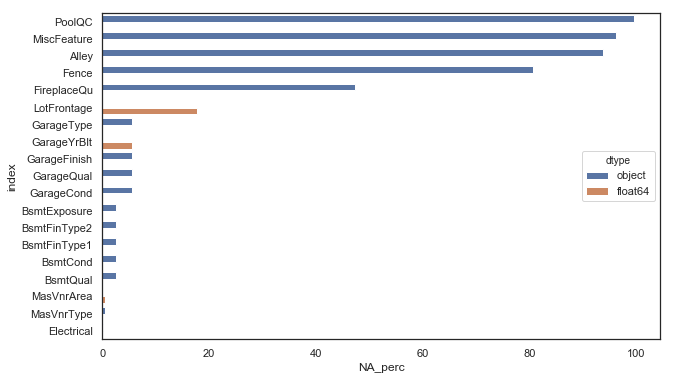

In [5]:
# aggregate all null values 
df_null = train.isna().sum()*100/train.shape[0]
df_null = df_null.reset_index()
df_null.rename(columns={0:'NA_perc'},inplace=True)
df_null['dtype'] = train.dtypes.values

# get rid of all the values with 0 missing values
df_null = df_null[df_null['NA_perc']>0].sort_values(by='NA_perc',ascending=False)
fig,ax = plt.subplots(1,figsize =(10,6))
sns.barplot(x=df_null['NA_perc'],y=df_null['index'],hue=df_null['dtype'])
#df_null.plot(kind='bar');

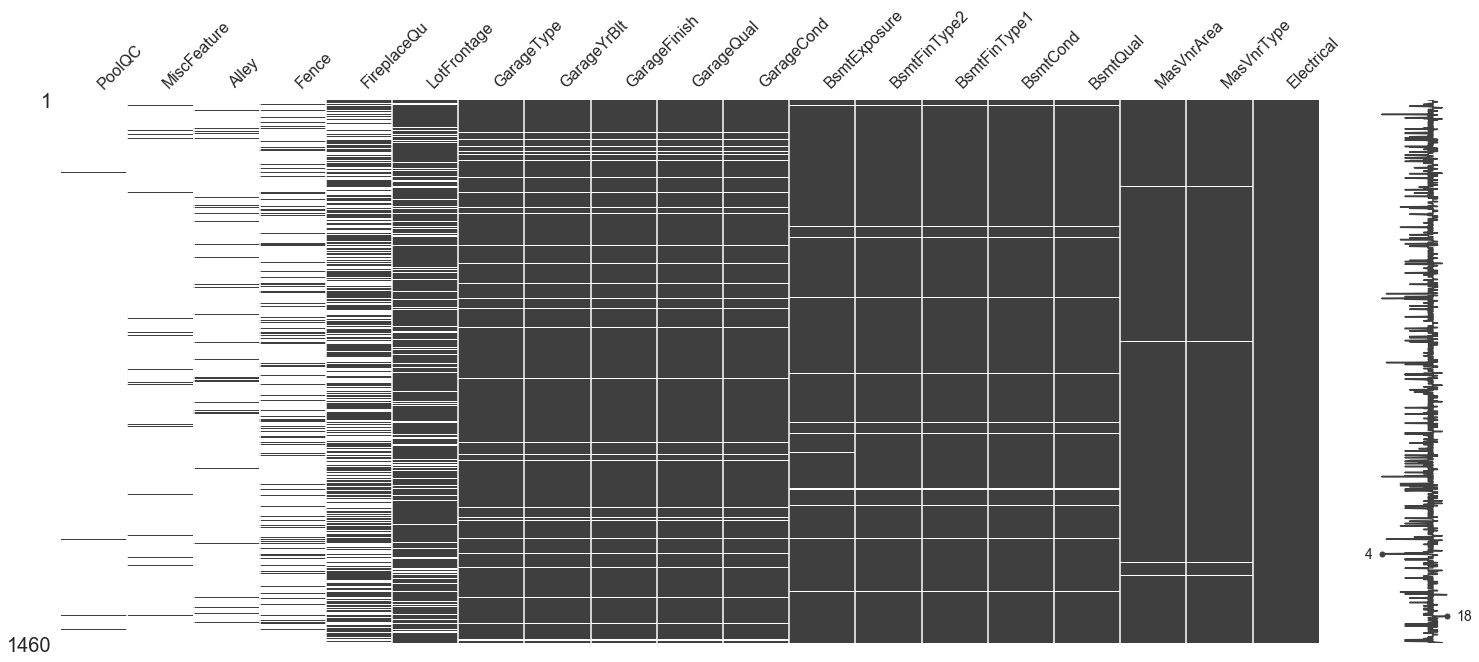

In [74]:
msno.matrix(train[df_null['index'].values])

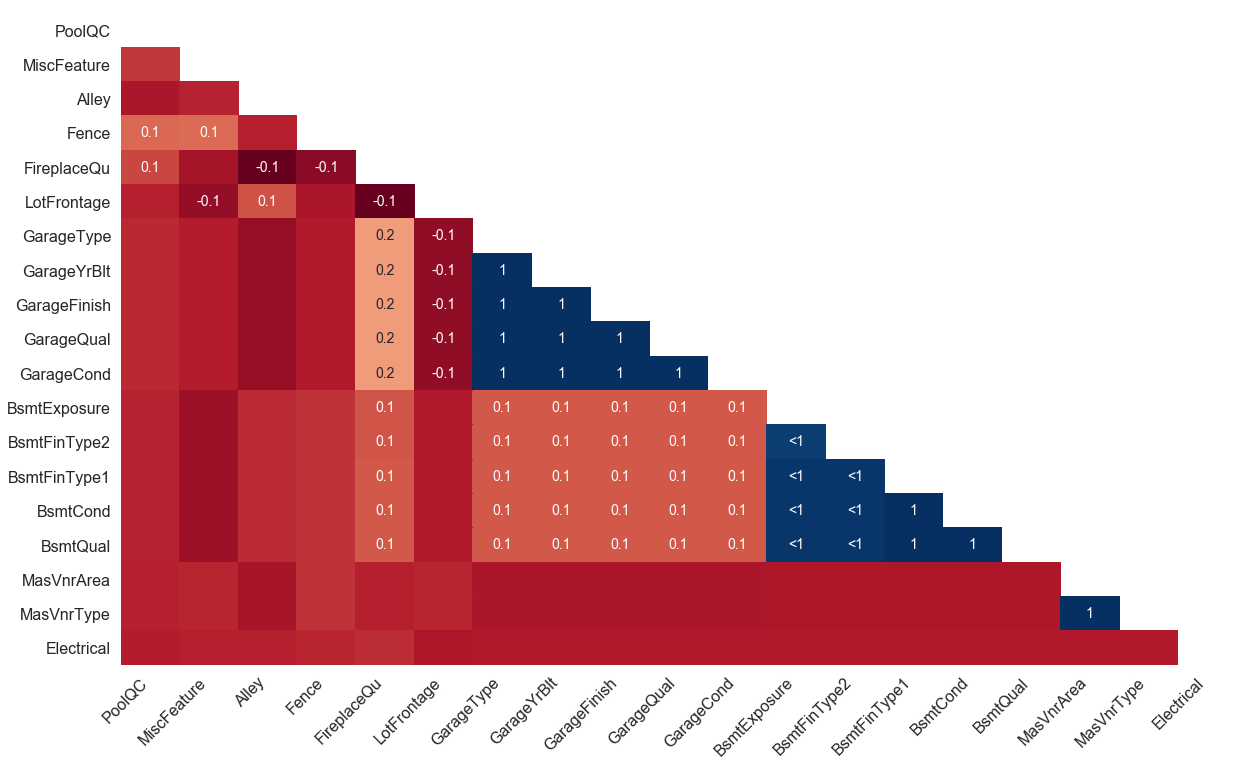

In [75]:
msno.heatmap(train[df_null['index'].values])

All the Missing Value Associated withh Garage and Basement Happens together. So, that's why we can see missing data is associated with the not having that variable in the house

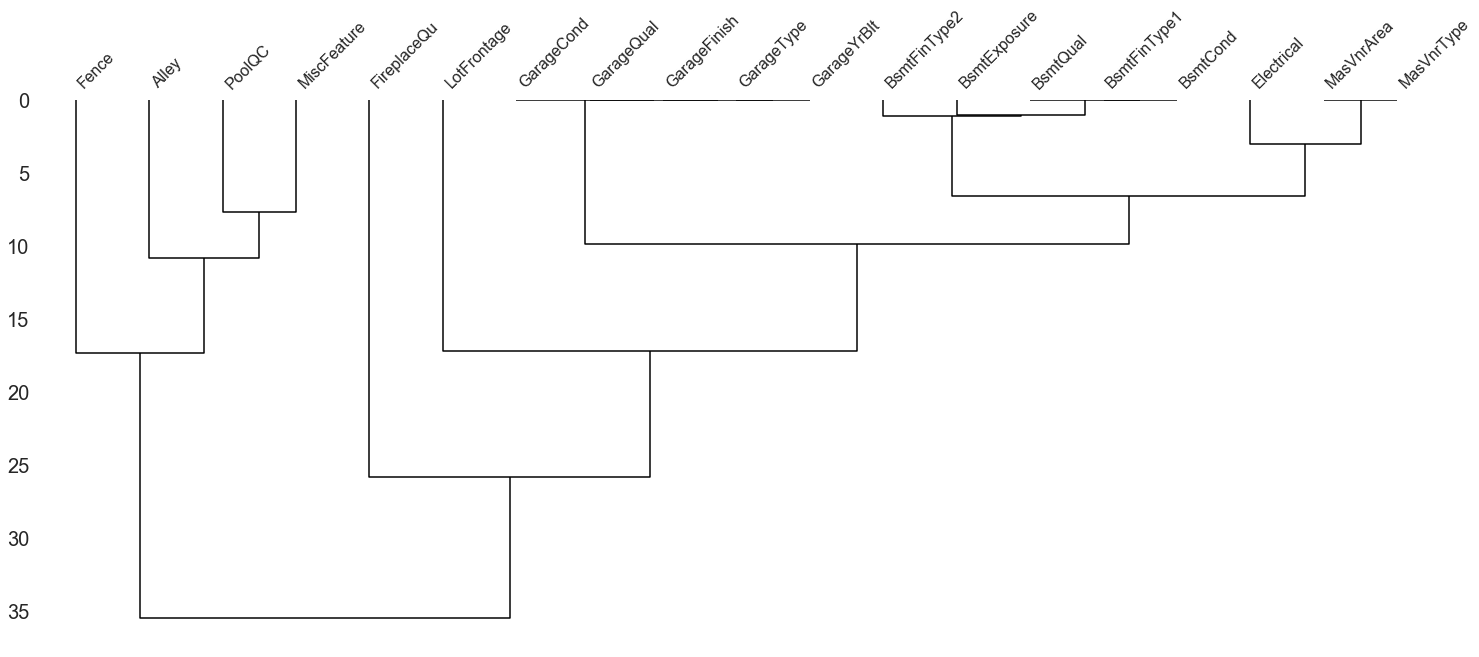

In [76]:
msno.dendrogram(train[df_null['index'].values])

## Imputing Missing Data


EDA on missing data

In [6]:
missing_cat_columns = df_null['index'].values[train[df_null['index']].dtypes == 'object']
missing_num_columns = df_null['index'].values[train[df_null['index']].dtypes == 'float64']

In [15]:
# assigning Category missing data
cat_deal={}
for col in missing_cat_columns:
    print(col)
    print(train[col].value_counts())
    print('MissingPercentage:',train[col].isna().sum()*100/train.shape[0])
    print('Deal with Missing Data or not: Y or N ')
    mis_action = input()
    if mis_action == 'Y':
        print('How to deal with it? & do you want to flag the variable?')
        cat_action = input()
        cat_deal[col] = cat_action
        print('*'*50)
        
cat_deal

PoolQC
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
MissingPercentage: 99.52054794520548
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64
MissingPercentage: 96.3013698630137
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64
MissingPercentage: 93.76712328767124
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64
MissingPercentage: 80.75342465753425
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
MissingPercentage: 47.26027397260274
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
GarageType
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
MissingPercentage: 5.5479452054794525
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,Yes


**************************************************
GarageFinish
Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64
MissingPercentage: 5.5479452054794525
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
GarageQual
TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64
MissingPercentage: 5.5479452054794525
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
GarageCond
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64
MissingPercentage: 5.5479452054794525
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
MissingPercentage: 2.6027397260273974
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,Yes


**************************************************
BsmtFinType2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
MissingPercentage: 2.6027397260273974
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
MissingPercentage: 2.5342465753424657
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
BsmtCond
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
MissingPercentage: 2.5342465753424657
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
MissingPercentage: 2.5342465753424657
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************
MasVnrType
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
MissingPercentage: 0.547945205479452
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 None,No


**************************************************
Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
MissingPercentage: 0.0684931506849315
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 NA,No


**************************************************


{'PoolQC': 'NA,No',
 'MiscFeature': 'NA,No',
 'Alley': 'NA,No',
 'Fence': 'NA,No',
 'FireplaceQu': 'NA,No',
 'GarageType': 'NA,Yes',
 'GarageFinish': 'NA,No',
 'GarageQual': 'NA,No',
 'GarageCond': 'NA,No',
 'BsmtExposure': 'NA,Yes',
 'BsmtFinType2': 'NA,No',
 'BsmtFinType1': 'NA,No',
 'BsmtCond': 'NA,No',
 'BsmtQual': 'NA,No',
 'MasVnrType': 'None,No',
 'Electrical': 'NA,No'}

In [10]:
def cat_impute(column,impute_type,flag_type):
    """Generic Function to impute missing data
    Based on Certain Type
    Input:
        column = Column you want to impute
        impute_type = categorical impute type
    Output:
        imputed column
    """
    
    if impute_type =='NA':
        impute_column = column.fillna('NA')
    if impute_type =='None':
        impute_column = column.fillna('None')    
    
    if flag_type=='Yes':
        flag_col = np.array(column.isna(),dtype='int64')
        return impute_column, flag_col
    else:
        return impute_column

In [11]:
for key,value in cat_deal.items():
    print(key,value)
    impute_type,flag_type = value.split(',')
    if flag_type == 'Yes':
        x,y = cat_impute(train[key],impute_type,flag_type)
        train[key] = x
        train['isna_'+key] =y
    else:
        train[key] =cat_impute(train[key],impute_type,flag_type)
    

PoolQC NA,No
MiscFeature NA,No
Alley NA,No
Fence NA,No
FireplaceQu NA,No
GarageType NA,Yes
GarageFinish NA,No
GarageQual NA,No
GarageCond NA,No
BsmtExposure NA,Yes
BsmtFinType2 NA,No
BsmtFinType1 NA,No
BsmtCond NA,No
BsmtQual NA,No
MasVnrType None,No
Electrical NA,No


In [157]:
# Saveing Dictionary for FUture use
np.save('categorical_impute.npy', cat_deal) 

#read_dictionary = np.load('my_file.npy').item()
#print(read_dictionary['hello']) # displays "world"

In [7]:
cat_deal = np.load('categorical_impute.npy').item()

In [24]:
train.columns[train.isna().sum()*100/train.shape[0] >0]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [119]:
num_deal={}
for col in missing_num_columns:
    print(col)
    print(train[col].describe())
    print('MissingPercentage:',train[col].isna().sum()*100/train.shape[0])
    print('Deal with Missing Data or not: Y or N ')
    mis_action = input()
    if mis_action == 'Y':
        print('How to deal with it? & do you want to flag the variable?')
        cat_action = input()
        num_deal[col] = cat_action
        print('*'*50)
        
num_deal

LotFrontage
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
MissingPercentage: 17.73972602739726
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 0,No


**************************************************
GarageYrBlt
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
MissingPercentage: 5.5479452054794525
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 0,Yes


**************************************************
MasVnrArea
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
MissingPercentage: 0.547945205479452
Deal with Missing Data or not: Y or N 


 Y


How to deal with it? & do you want to flag the variable?


 KNN,Yes


**************************************************


{'LotFrontage': '0,No', 'GarageYrBlt': '0,Yes', 'MasVnrArea': 'KNN,Yes'}

In [156]:
# Saveing Dictionary for FUture use
np.save('numerical_impute.npy', num_deal) 

#read_dictionary = np.load('my_file.npy').item()
#print(read_dictionary['hello']) # displays "world"

In [14]:
def num_impute(data,column_name,impute_type,flag_type):
    """Generic Function to impute missing data
    Based on Certain Type
    Input:
        column = Column you want to impute
        impute_type = categorical impute type
    Output:
        imputed column
    """
    column = data[column_name]
    if impute_type =='0':
        impute_column = column.fillna(0)
    if impute_type =='KNN':
        impute = KNNImputer()
        impute.fit(df=data, col=column_name) 
        X_data = impute.transform(data)
        impute_column = X_data[column_name]
    
    if flag_type=='Yes':
        flag_col = np.array(column.isna(),dtype='int64')
        return impute_column, flag_col
    else:
        return impute_column

In [105]:
#KNeighborsRegressor?

In [13]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer
class KNNImputer:
    def __init__(self,k=10):
        self.regressors = {}
        self.k = k
    def fit(self,df, col):
        # Using only continuous values to find out the missing value
        # In future we can add the variable for the modeling aproch
        input_features = [c for c in df.columns if (c != col)&(df[c].dtype !='object')]
        # Using Only column that does not having missing value is used for our modeling approch
        input_features = np.array(input_features)[(df[input_features].isna().sum()*100/df.shape[0]) ==0]
        output_features = col
        
        regressor = KNeighborsRegressor(self.k)
        
        train = df[~(df[output_features].isna())]
        regressor.fit(train[input_features],train[output_features])
        
        self.regressor = regressor
        self.input_features = input_features
        self.output_features = output_features
        return self

    def transform(self, df):
        
        # For transforming we can use the direct saved regressor
        # on missing value points
        
        test = df[df[self.output_features].isna()]
        x = test[self.input_features]
        regressor = self.regressor
        y = regressor.predict(x)
        df.loc[df[self.output_features].isna(),self.output_features]=y
        return df

In [15]:
for key,value in num_deal.items():
    print(key,value)
    impute_type,flag_type = value.split(',')
    if flag_type == 'Yes':
        x,y = num_impute(train,key,impute_type,flag_type)
        train[key] = x
        train['isna_'+key] =y
    else:
        train[key] =num_impute(train,key,impute_type,flag_type)
    

LotFrontage 0,No
GarageYrBlt 0,Yes
MasVnrArea KNN,Yes


In [12]:
num_deal = np.load('numerical_impute.npy').item()

Dealing With Outliers

# Exploratory Data Analysis (EDA)

- Visualize training data using different kinds of plots
- Plot dependent variables (features) against independent variable (target label)

## Target Variable Analysis

In [143]:
unique_values_dict = {}
for col in train.columns:
    if col not in numerical_features:
        unique_value = str(np.sort(train[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  ['C (all)', 'FV', 'RH', 'RL', 'RM']
['MSZoning']
--------------------------------------------------
Columns containing the unique values :  ['Grvl', 'Pave']
['Street']
--------------------------------------------------
Columns containing the unique values :  ['Grvl', 'NA', 'Pave']
['Alley']
--------------------------------------------------
Columns containing the unique values :  ['IR1', 'IR2', 'IR3', 'Reg']
['LotShape']
--------------------------------------------------
Columns containing the unique values :  ['Bnk', 'HLS', 'Low', 'Lvl']
['LandContour']
--------------------------------------------------
Columns containing the unique values :  ['AllPub', 'NoSeWa']
['Utilities']
--------------------------------------------------
Columns containing the unique values :  ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
['LotConfig']
--------------------------------------------------
Columns containing the unique values :  ['Gtl', 'Mod', 'Sev']
['LandSlo

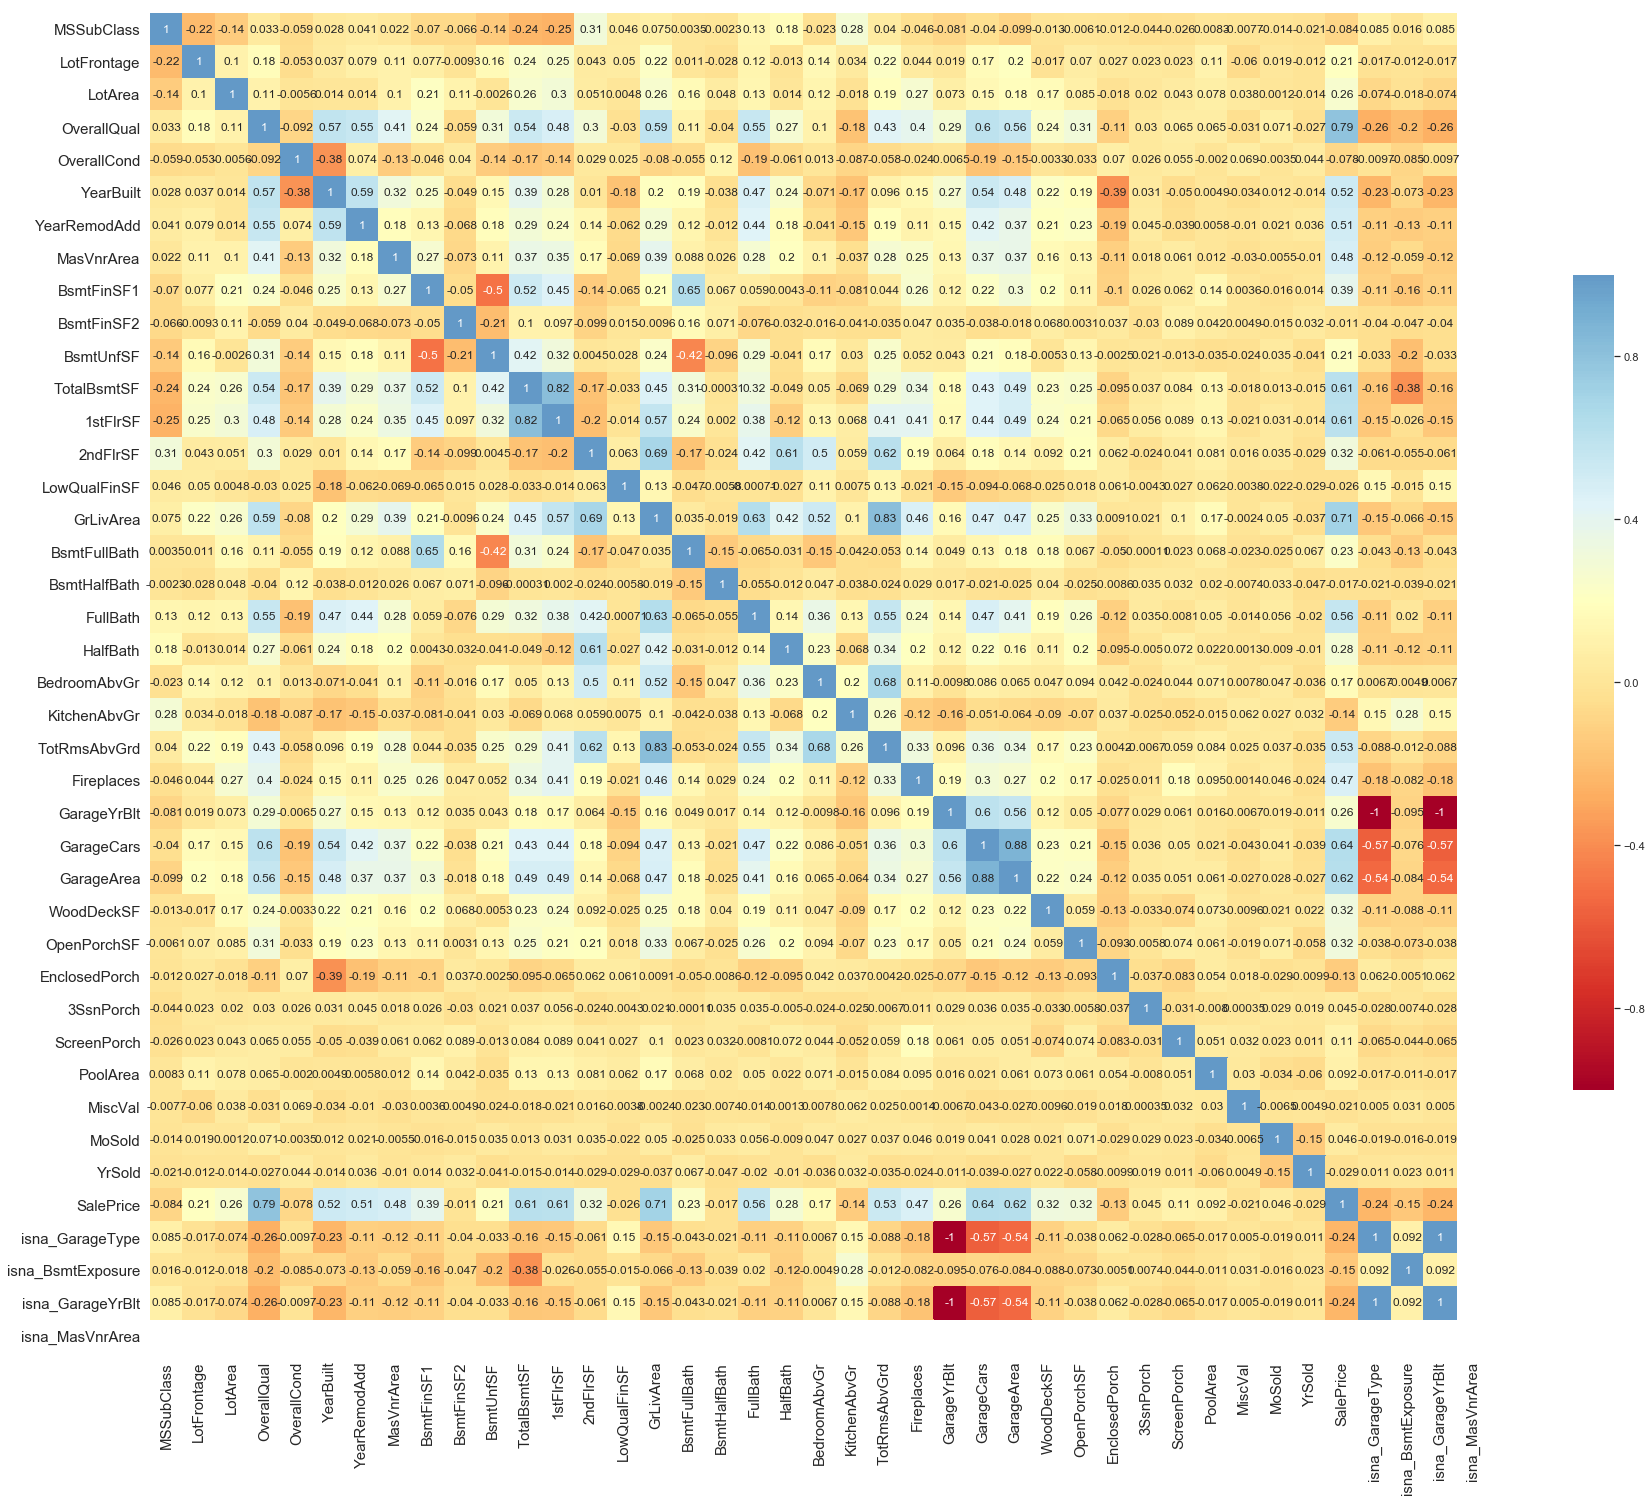

In [154]:

corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-1, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)

Correlation: -0.08428413512659517


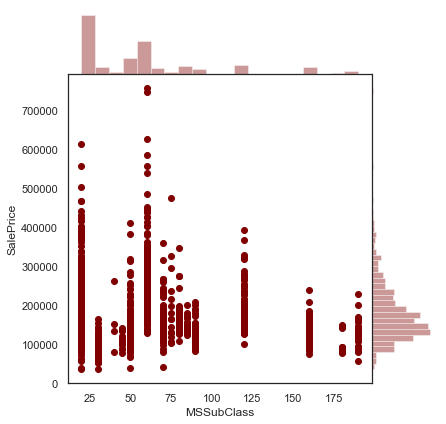

Correlation: 0.2096239447994839


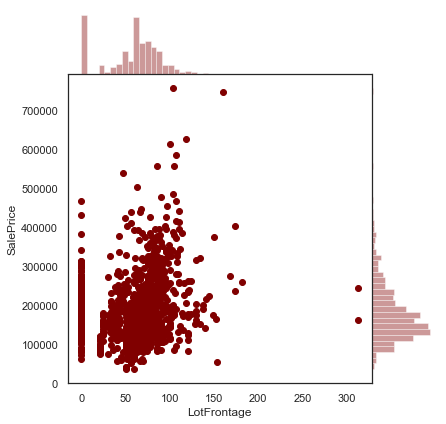

Correlation: 0.2638433538714056


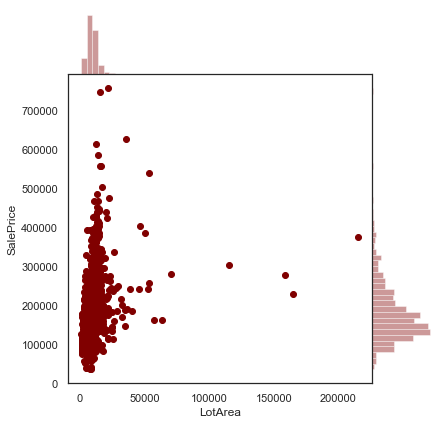

Correlation: 0.7909816005838051


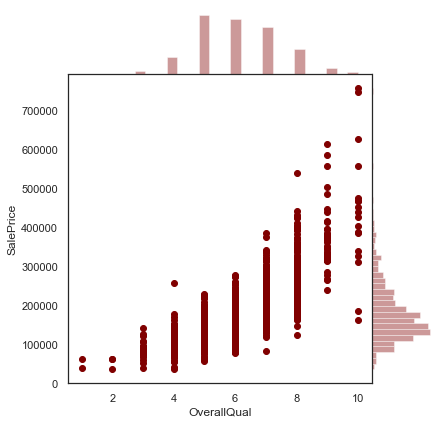

Correlation: -0.077855894048678


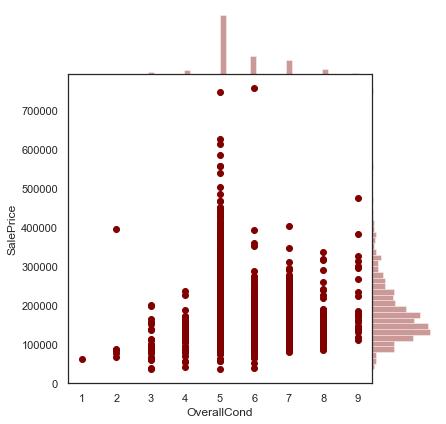

Correlation: 0.5228973328794969


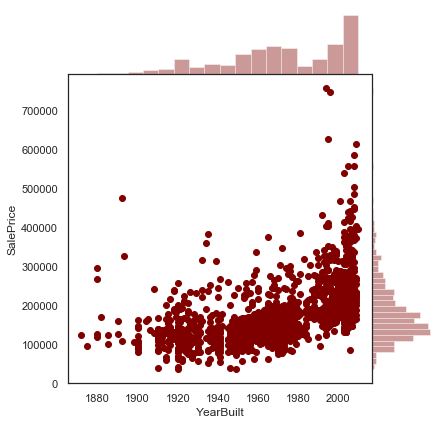

Correlation: 0.5071009671113862


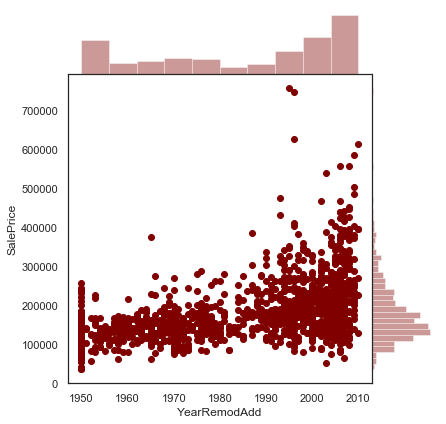

Correlation: 0.48038656921738093


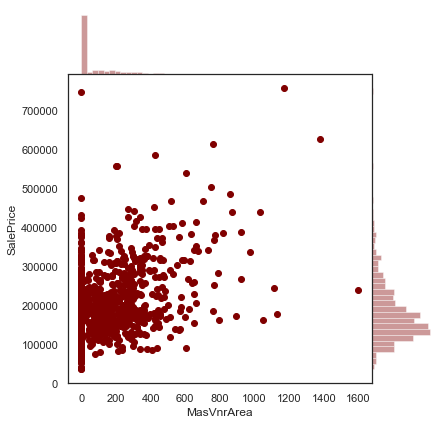

Correlation: 0.3864198062421533


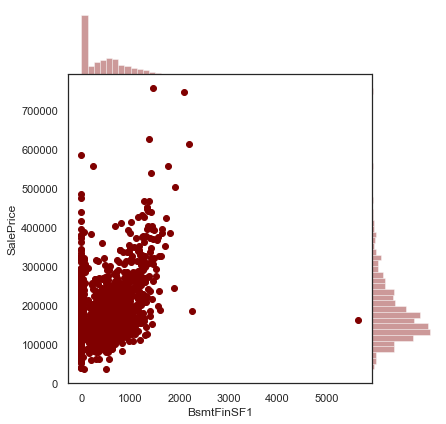

Correlation: -0.01137812145021514


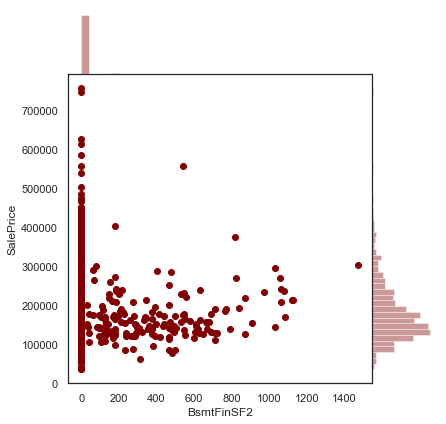

Correlation: 0.2144791055469689


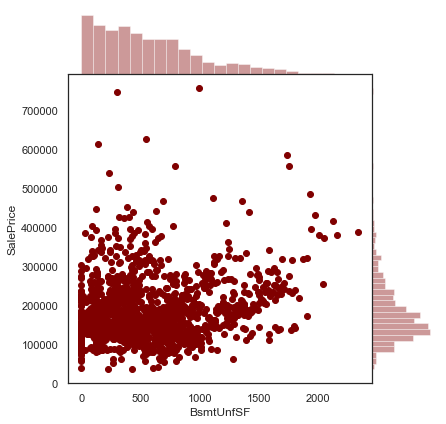

Correlation: 0.6135805515591953


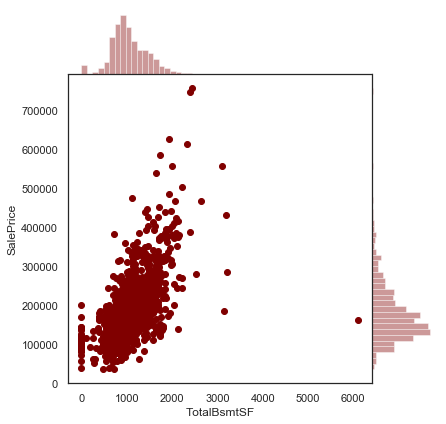

Correlation: 0.6058521846919146


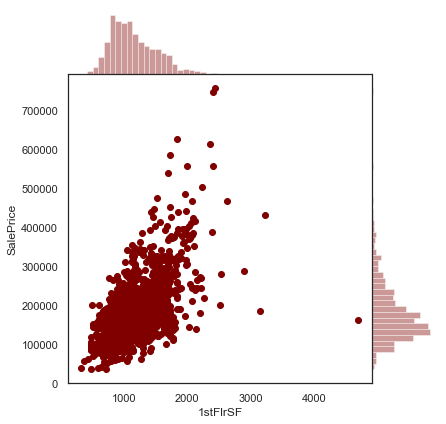

Correlation: 0.3193338028320678


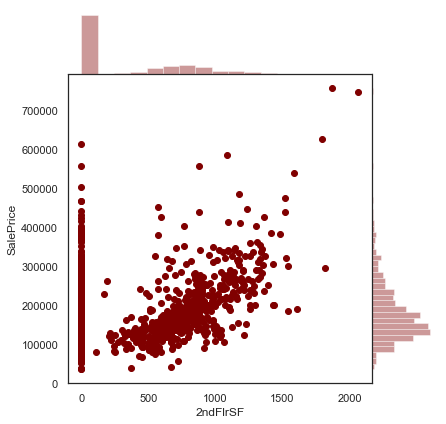

Correlation: -0.025606130000679534


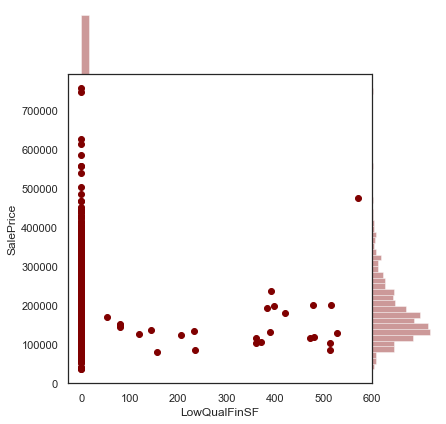

Correlation: 0.708624477612652


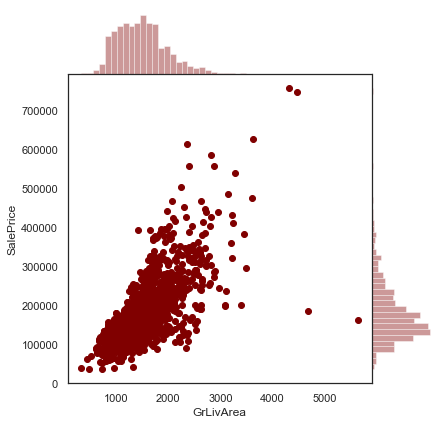

Correlation: 0.22712223313149424


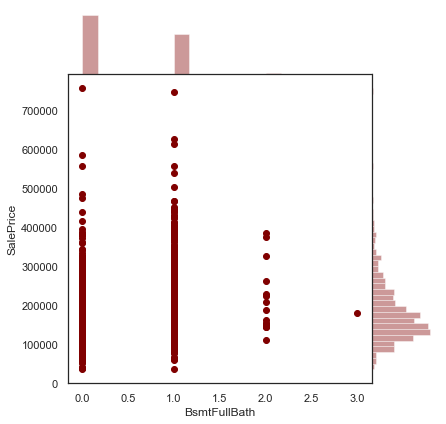

Correlation: -0.016844154297359016


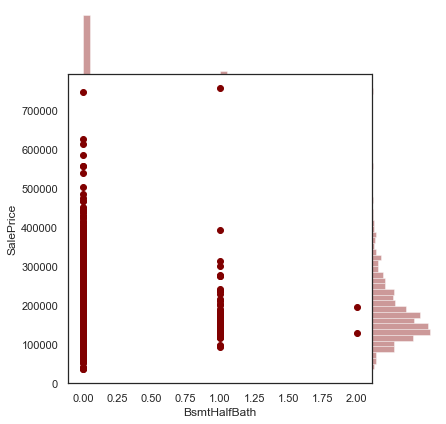

Correlation: 0.560663762748446


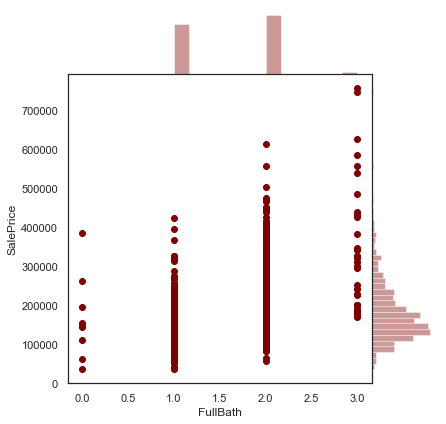

Correlation: 0.2841076755947825


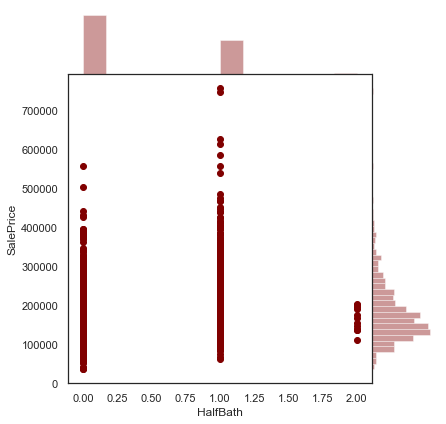

Correlation: 0.16821315430073996


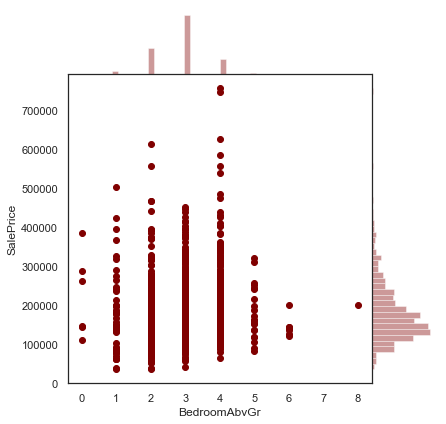

Correlation: -0.13590737084214122


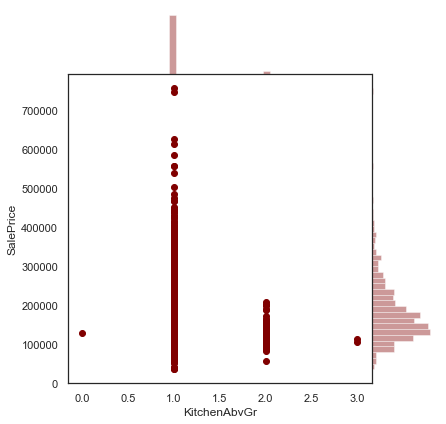

Correlation: 0.5337231555820281


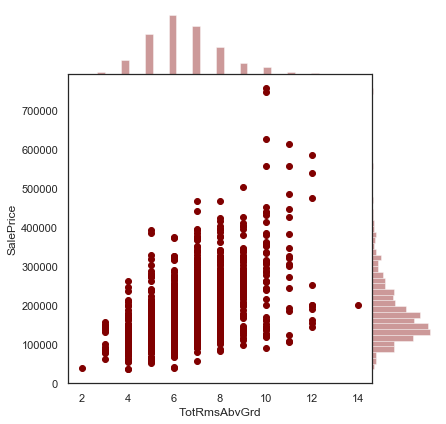

Correlation: 0.4669288367515278


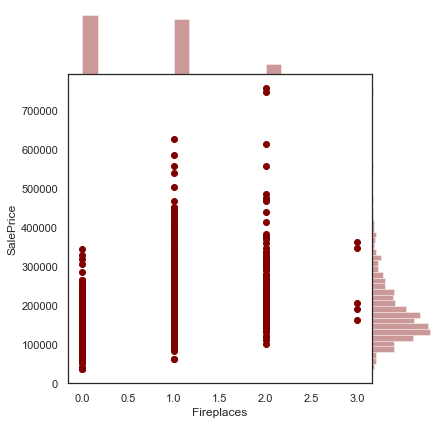

Correlation: 0.2613664351029631


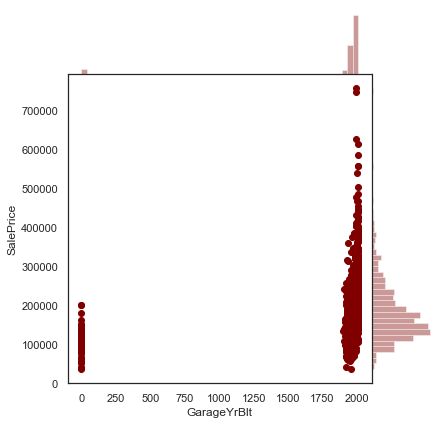

Correlation: 0.640409197258352


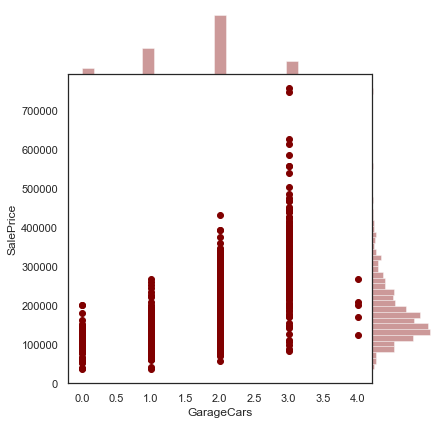

Correlation: 0.6234314389183616


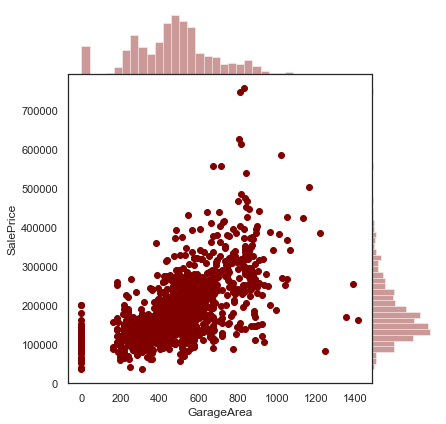

Correlation: 0.3244134445681299


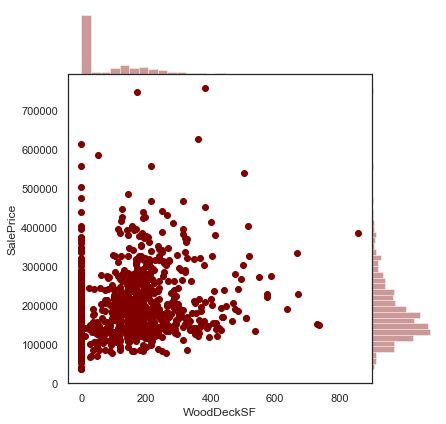

Correlation: 0.3158562271160552


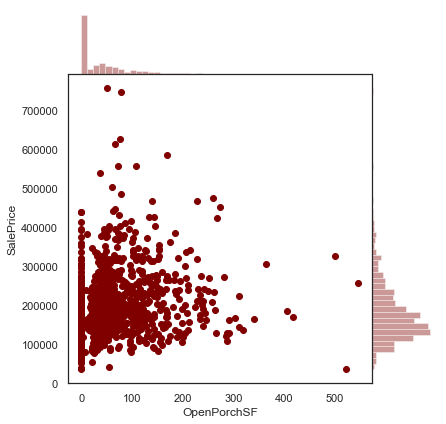

Correlation: -0.12857795792595675


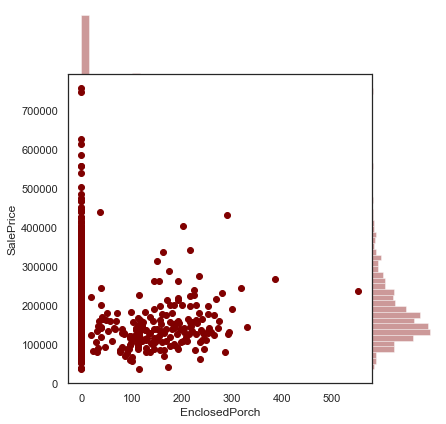

Correlation: 0.0445836653357484


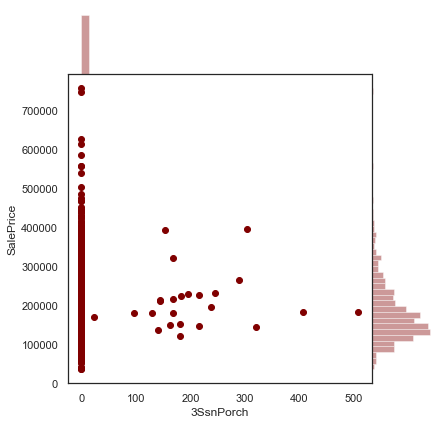

Correlation: 0.11144657114291123


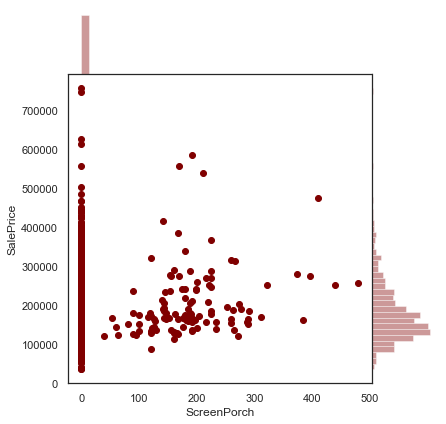

Correlation: 0.09240354949187321


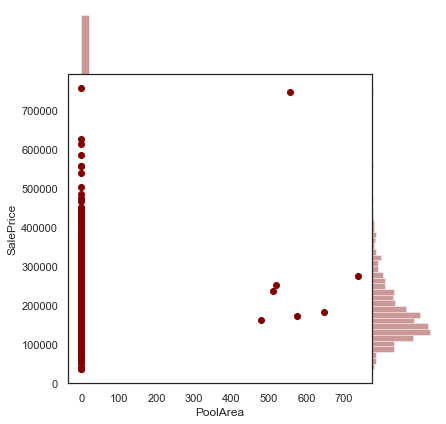

Correlation: -0.021189579640303255


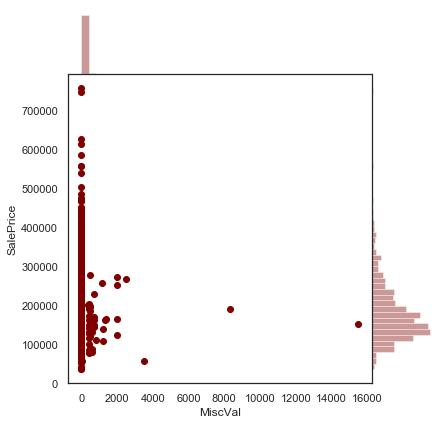

Correlation: 0.04643224522381935


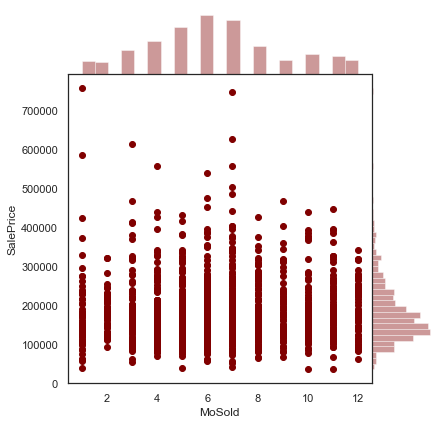

Correlation: -0.028922585168730326


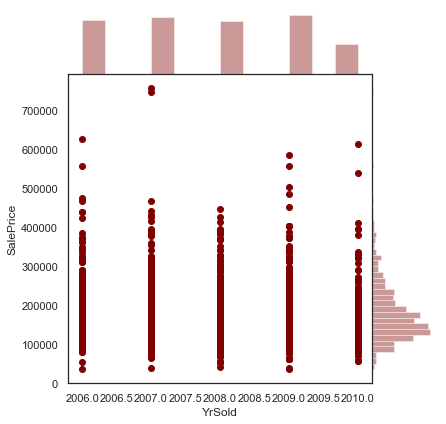

In [25]:
def numerical_plot(data,column,ycolumn):
    #fig,ax = plt.subplots(1,figsize=(8,8))
    sns.jointplot(x=column, y=ycolumn, data=data, size=6, kind='scatter', color='#800000', space=0,label='%2f'%pearsonr(data[column], data[ycolumn])[0])
    print('Correlation:',pearsonr(data[column], data[ycolumn])[0])
    #ax.set_ylabel(ycolumn)
    plt.show()
    
flag_variable_list={}
outlier_variable_list=[]
#transformation_variable = [] # Automating that process and convert that to directly to boxcox trnasformation
#sns.pairplot(data = train[numerical_columns])

numerical_features = [n for n in numerical_features if n !='SalePrice']

for var in numerical_features:
    numerical_plot(train,column=var,ycolumn='SalePrice')
#    print('Any Changes to Variable? Y or N')
#    changes = input()
#    if changes=='Y':
#        print('Do you want to flag the variable? Y or N')
#        flag_type = input()
#        if flag_type =='Y':
#            print('How to Flag? Threshold')
#            flag_tresh = input()
#            flag_variable_list[var] =flag_thresh
#        print('Deal With Outlier? Y or N')
#        out_type = input()
#        if out_type=='Y':
#            outlier_variable_list.append(var)

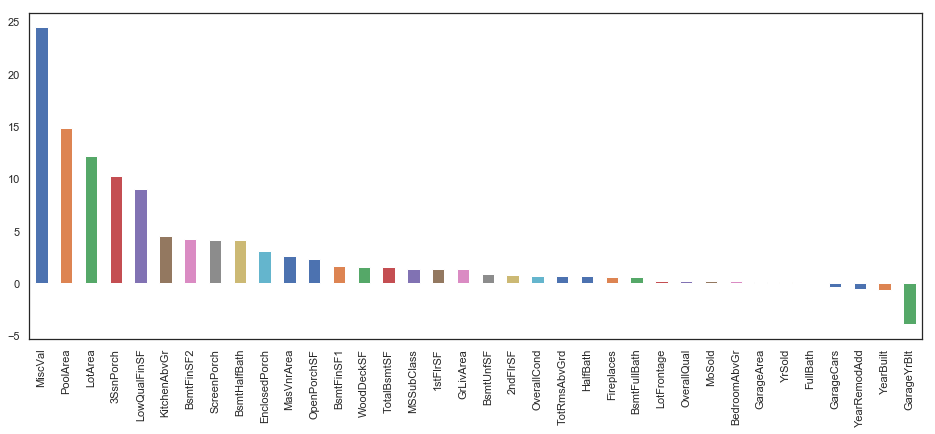

In [155]:
# CHecking Skewness of the variable and transforming to box cox transformation
# First lets single out the numeric features
numerical_features = [n for n in numerical_features if n !='SalePrice']
# Check how skewed they are
skewed_feats = train[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(16, 6))
skewed_feats.plot(kind='bar');

In [ ]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

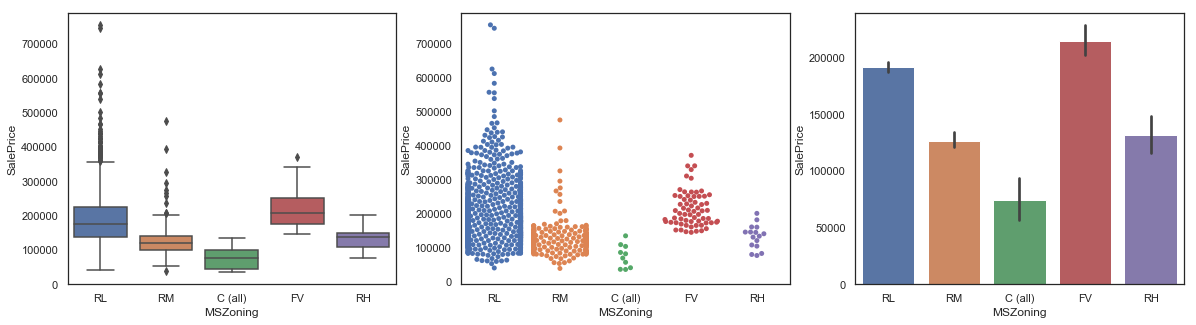

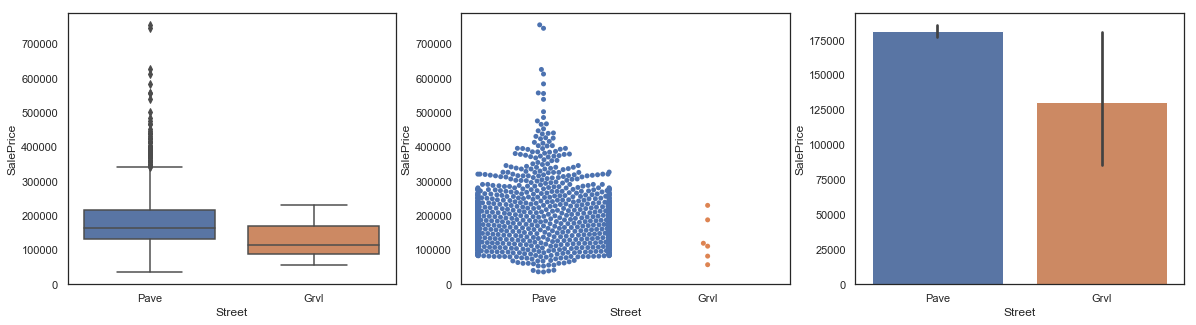

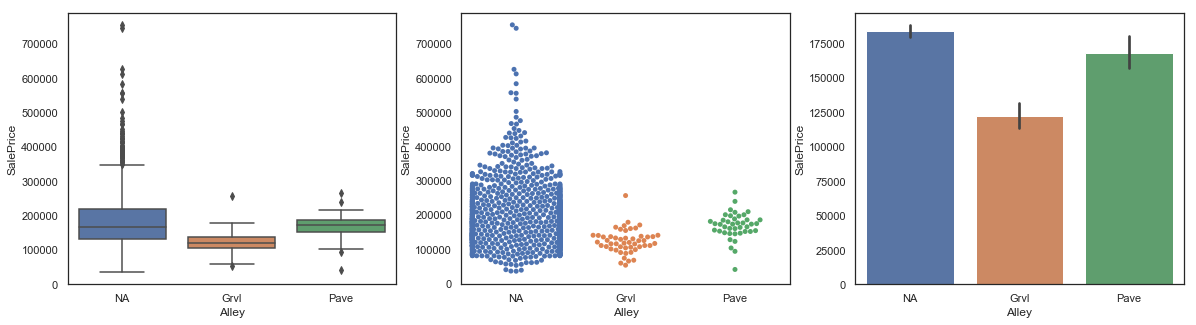

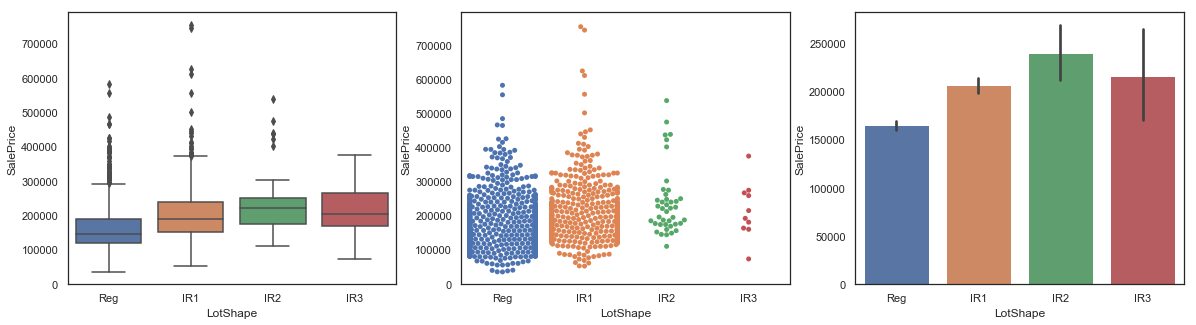

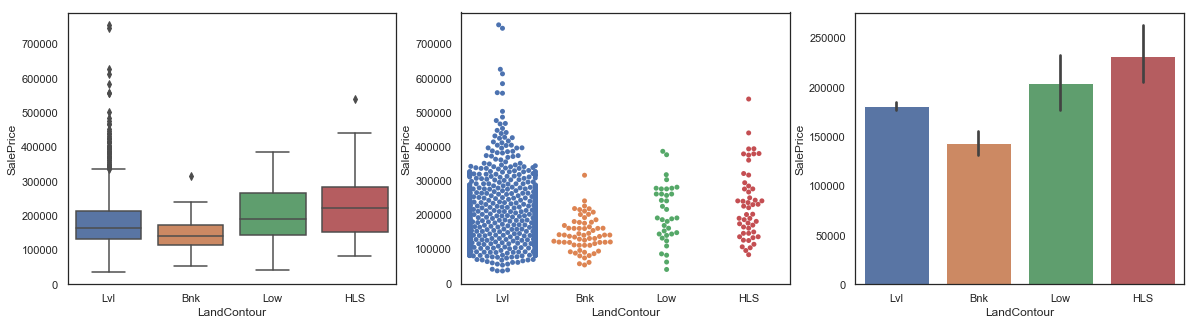

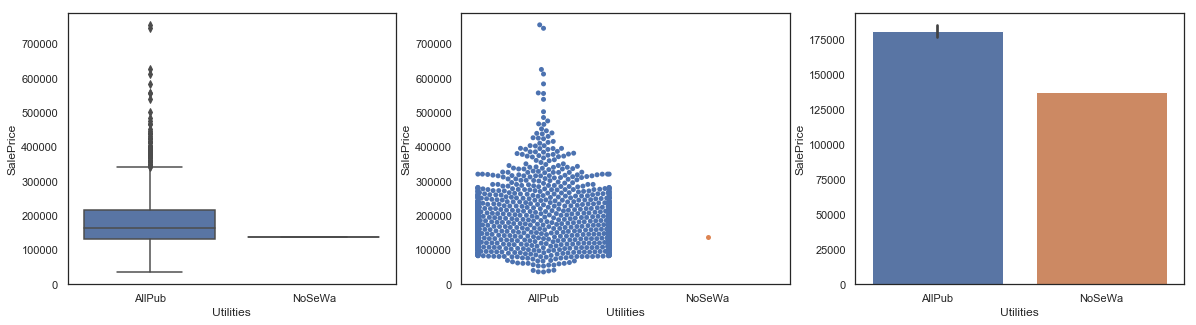

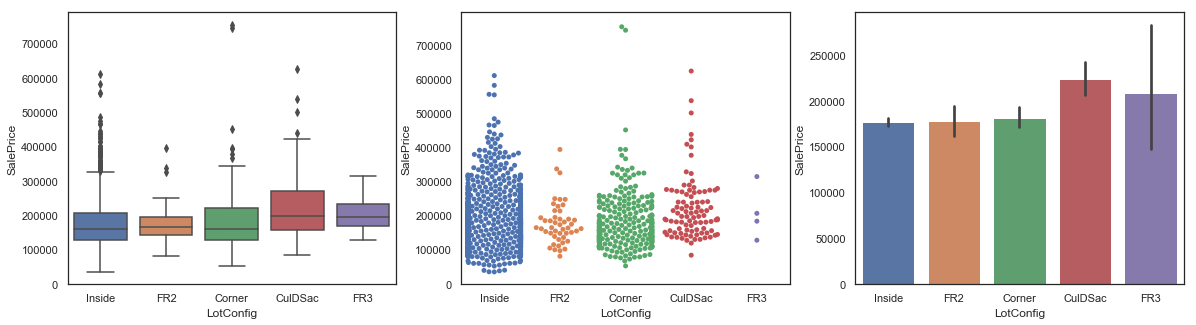

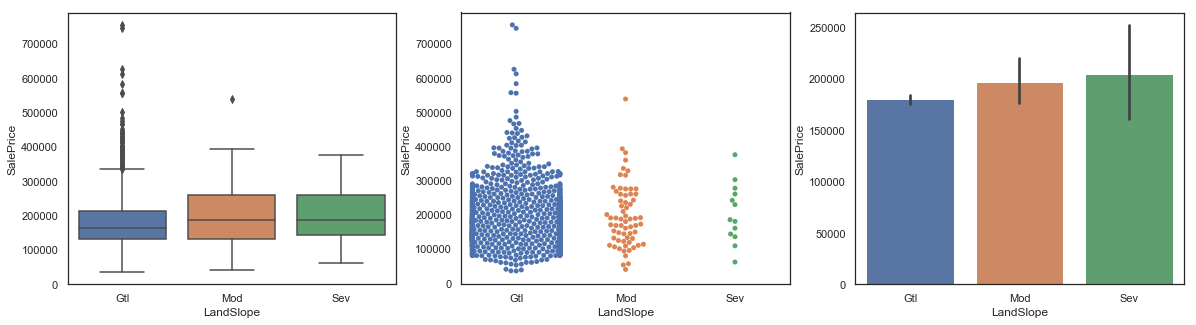

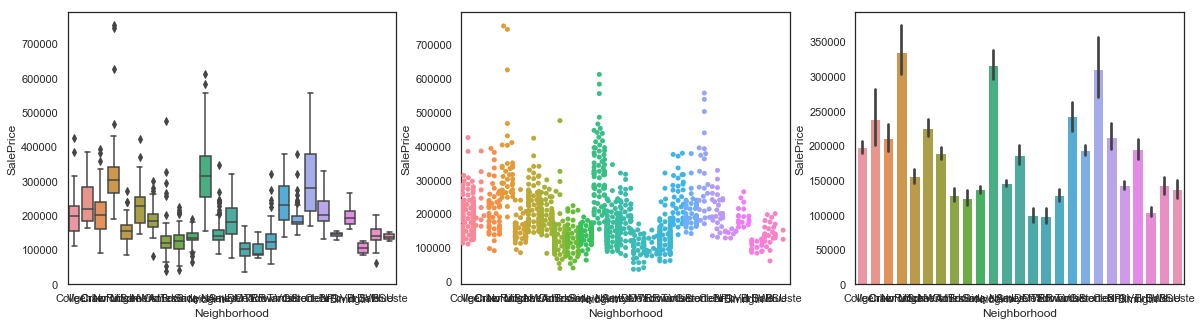

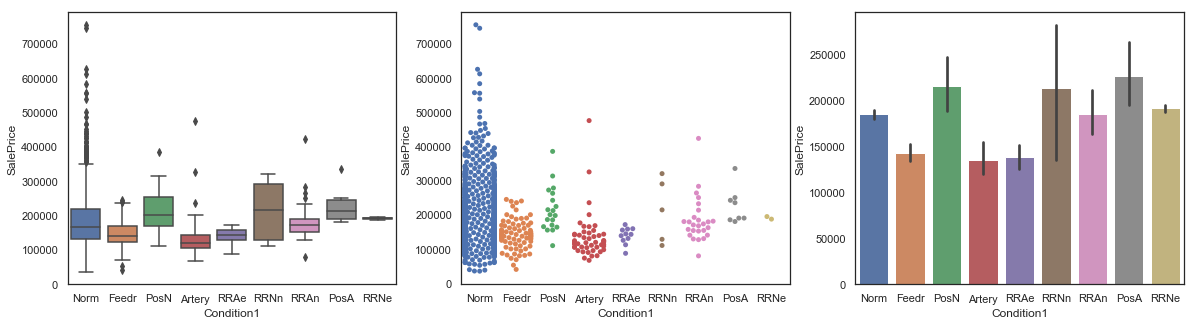

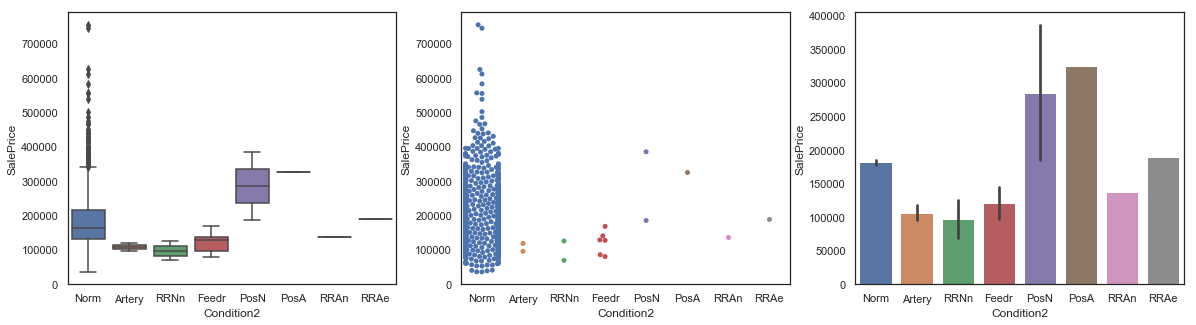

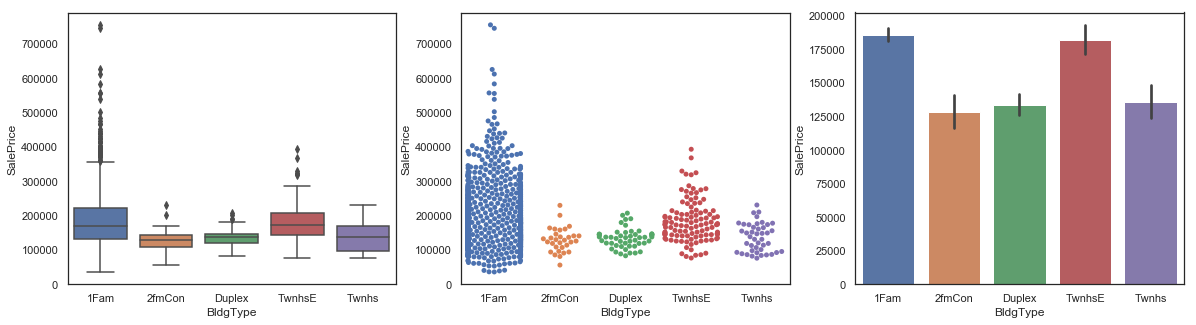

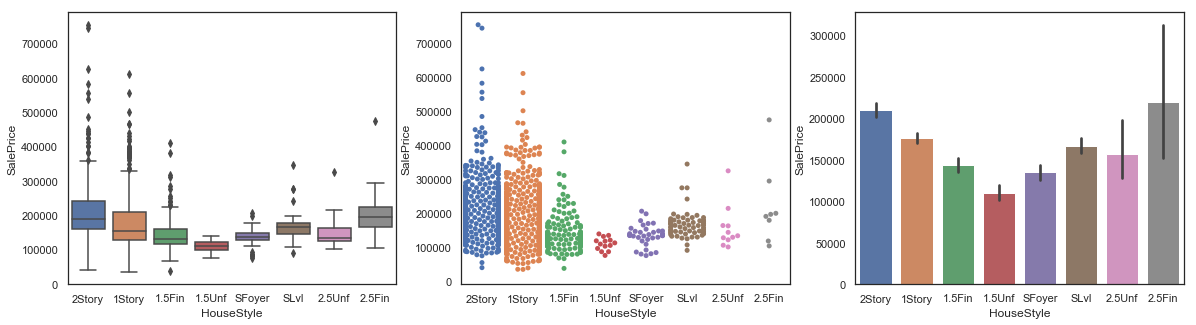

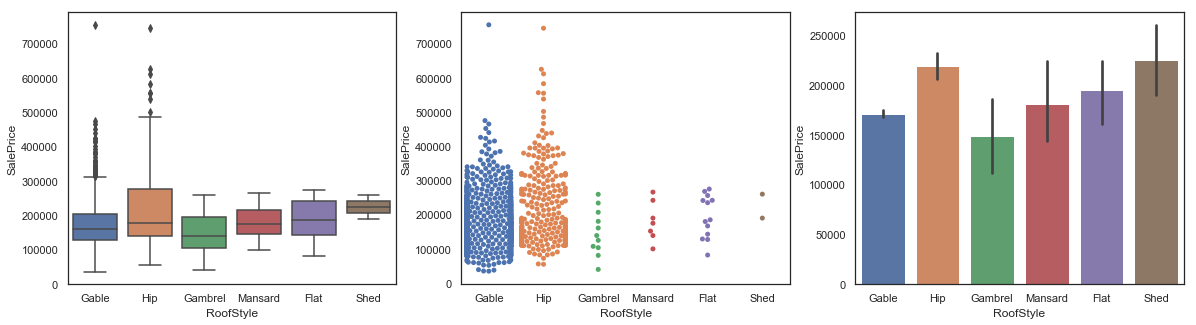

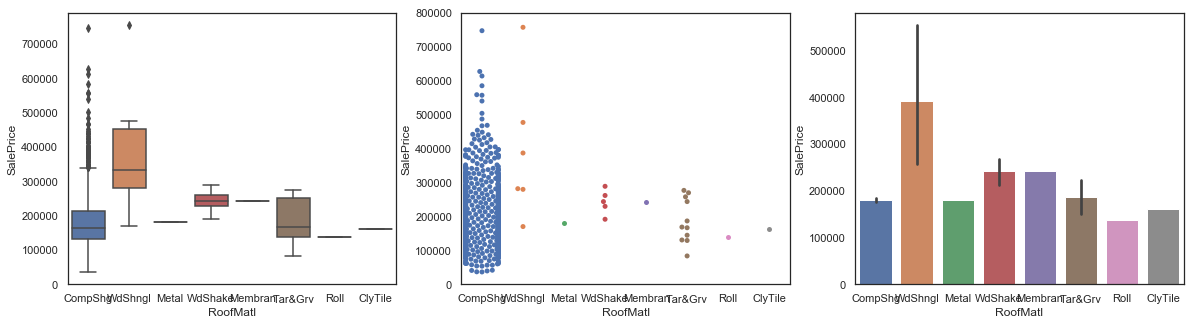

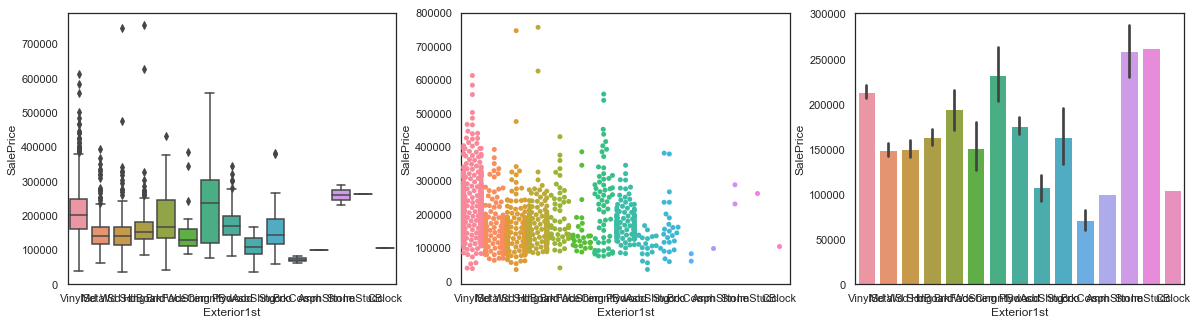

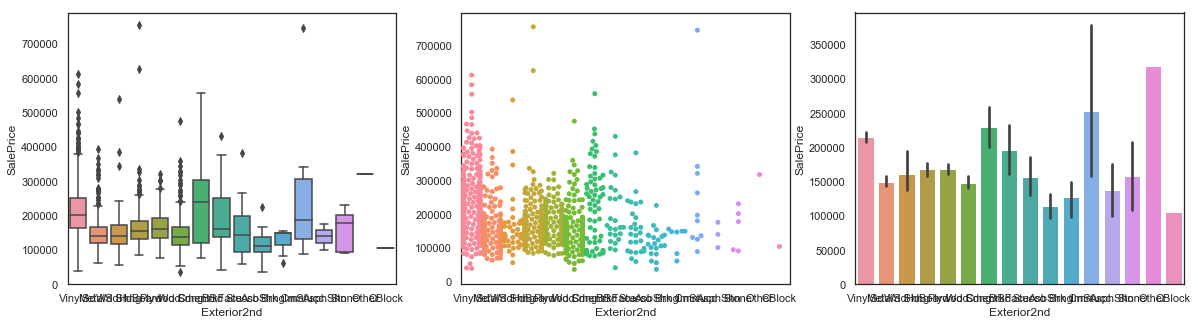

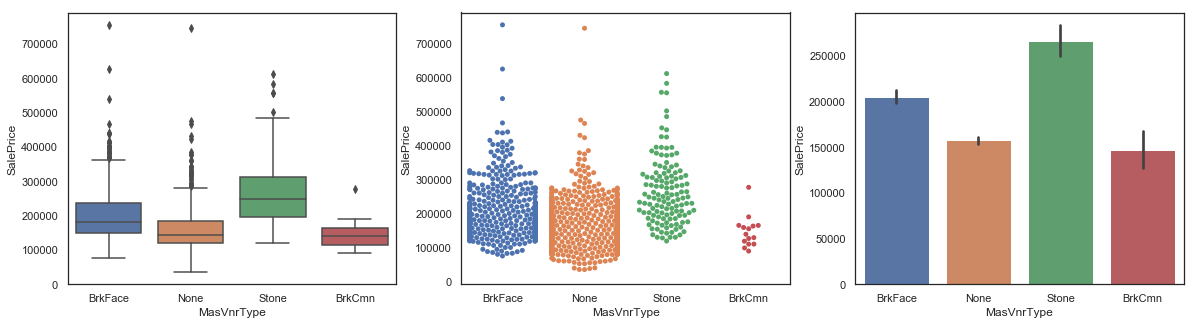

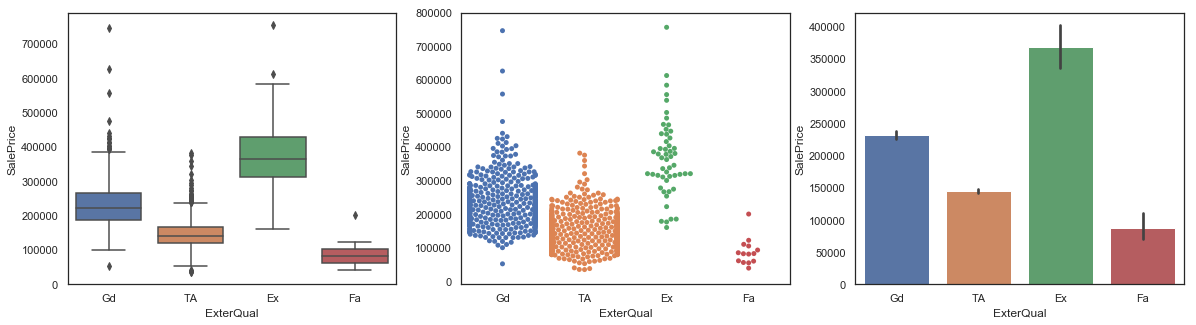

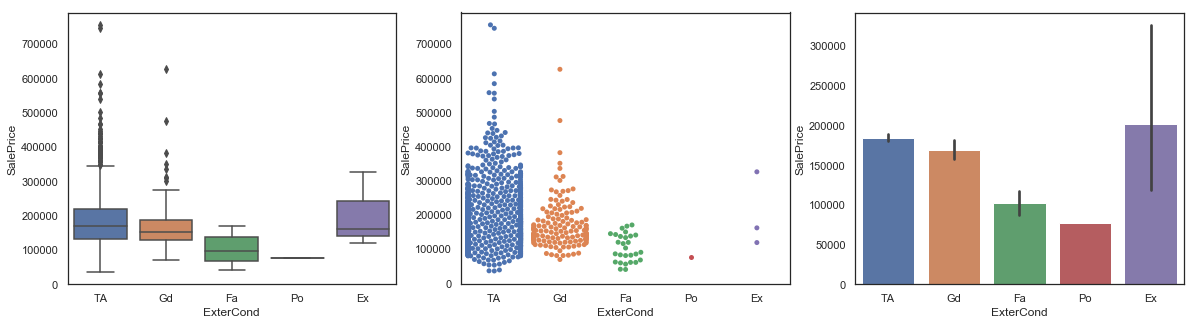

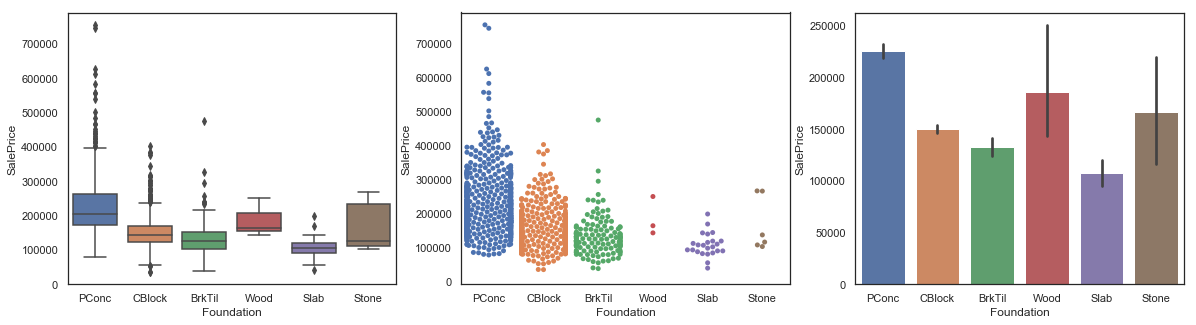

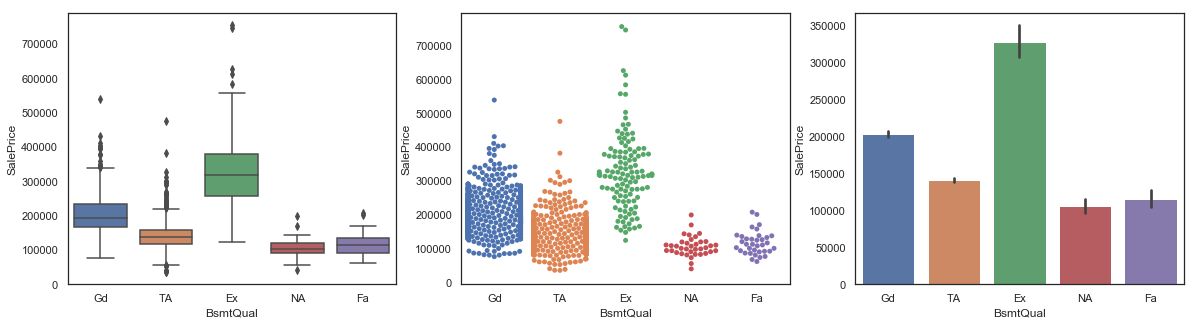

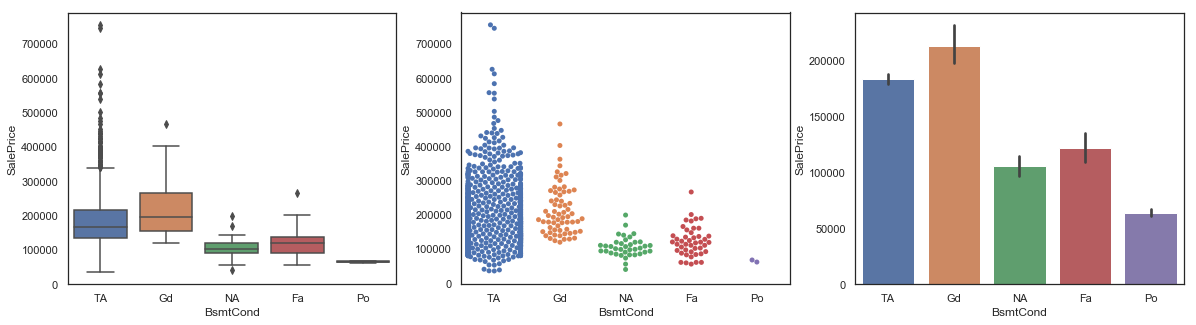

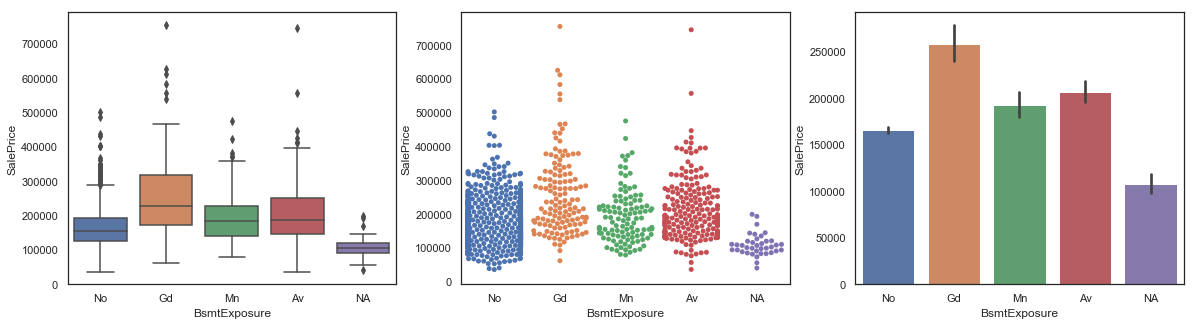

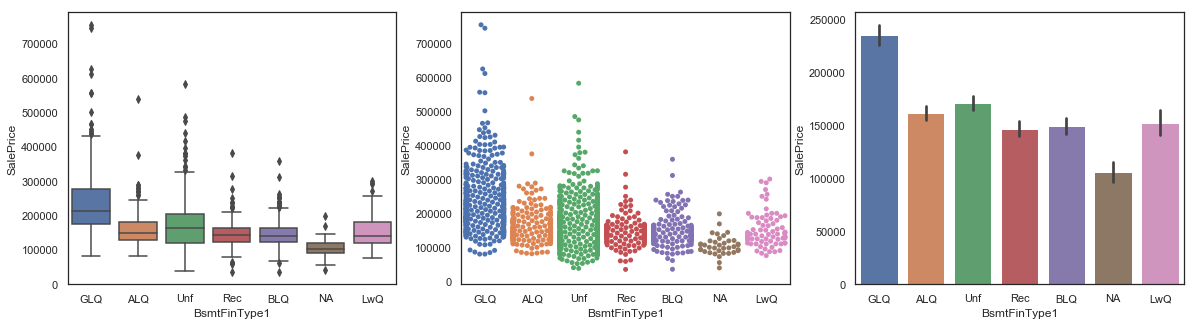

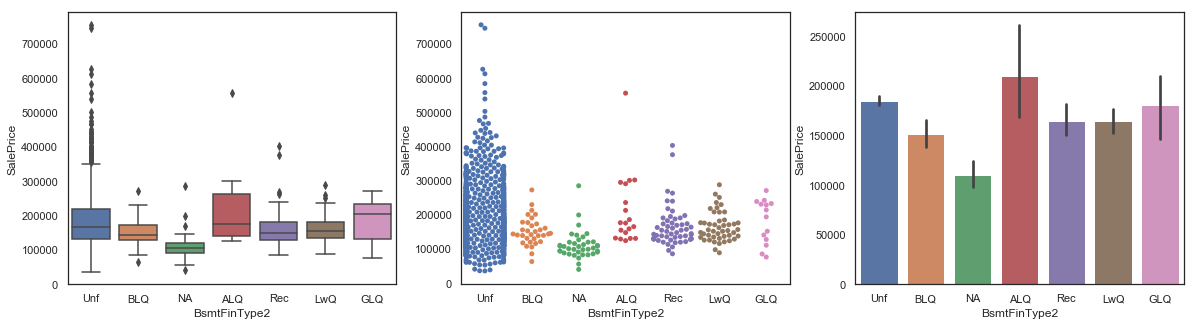

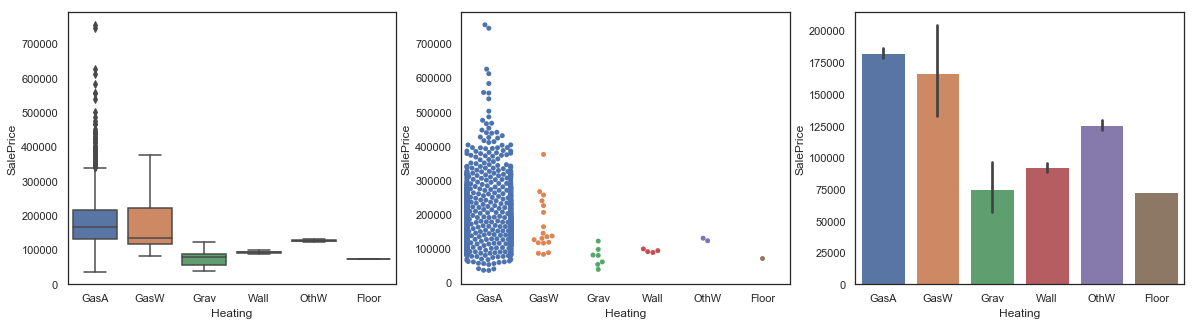

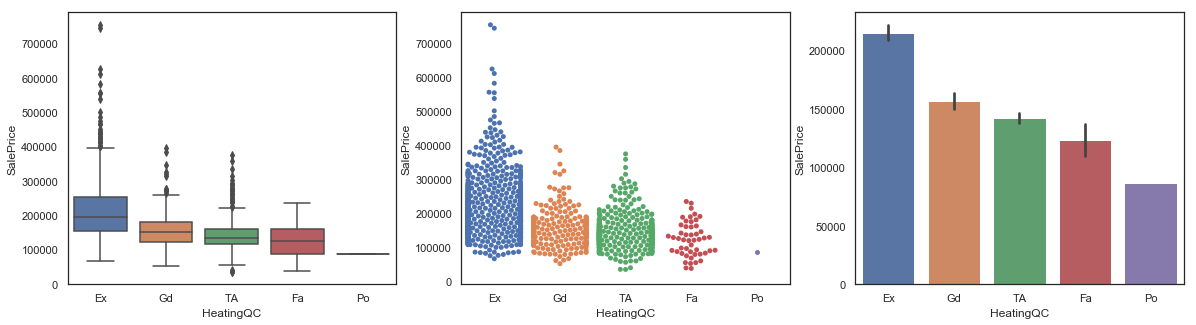

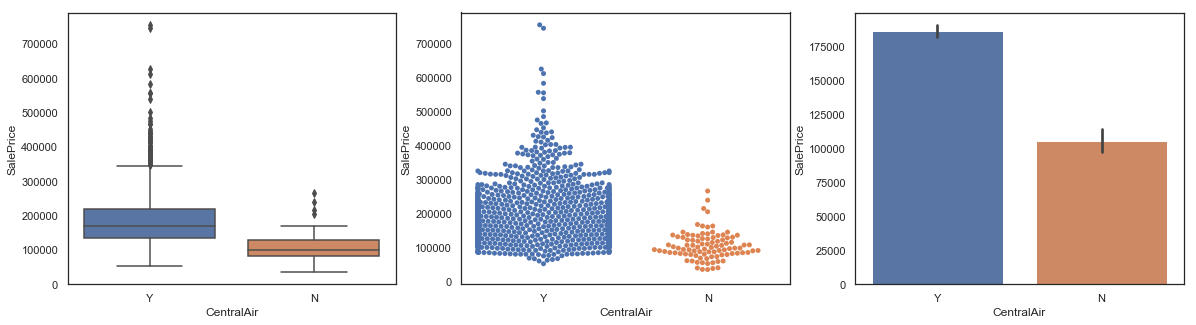

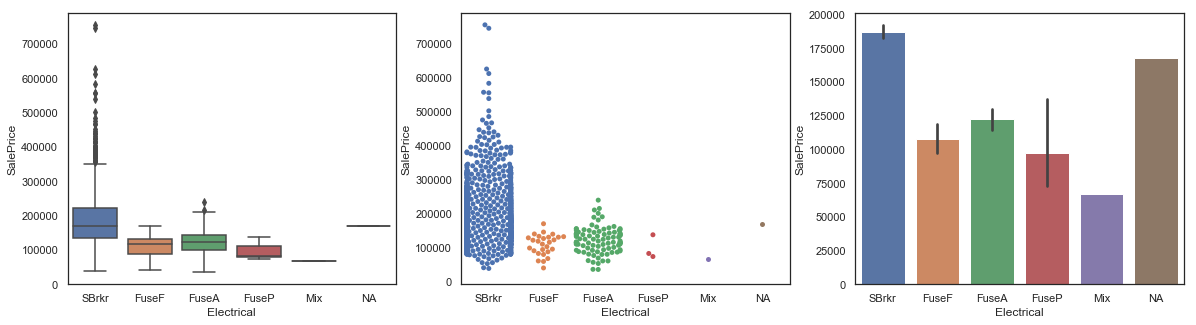

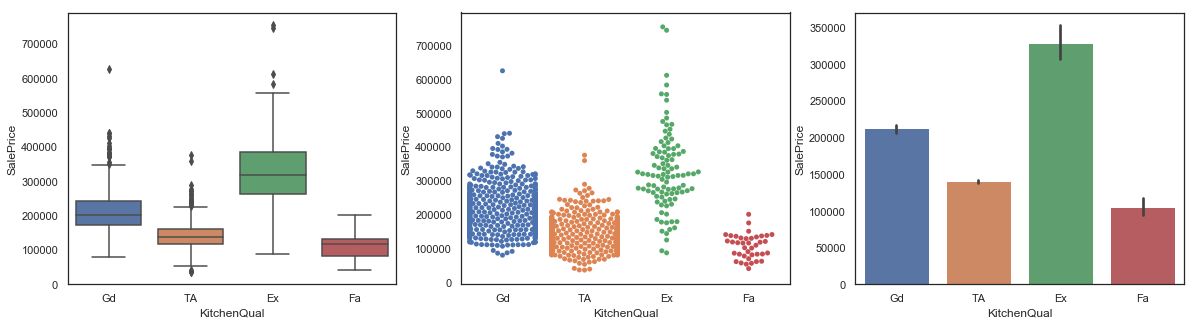

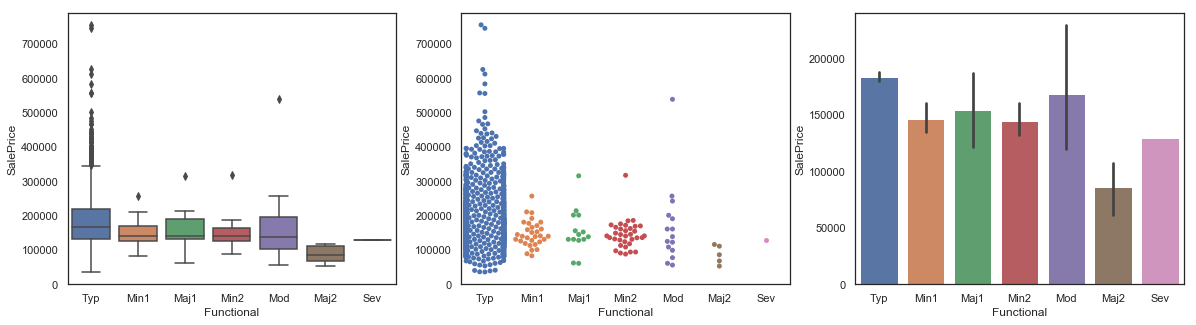

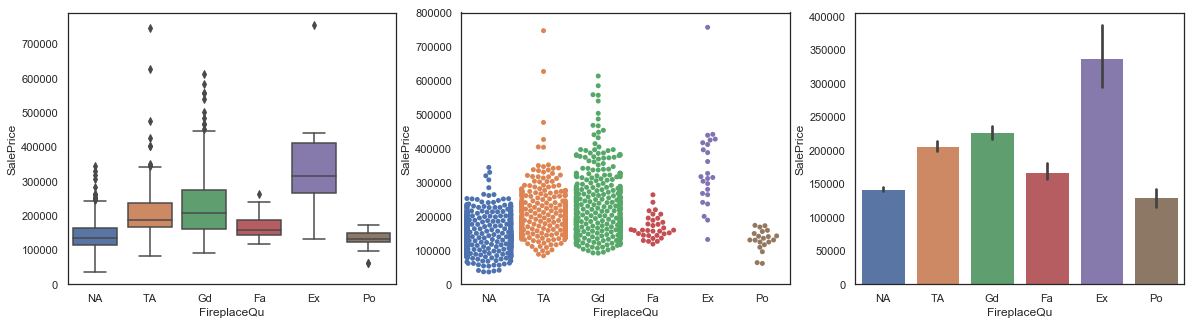

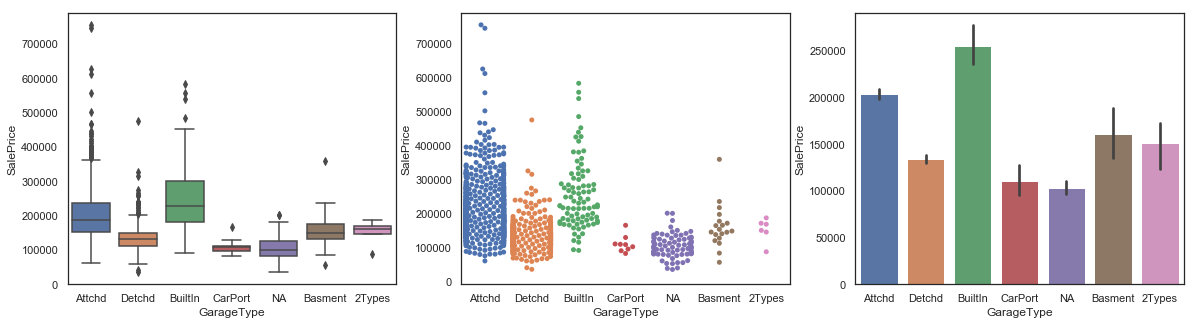

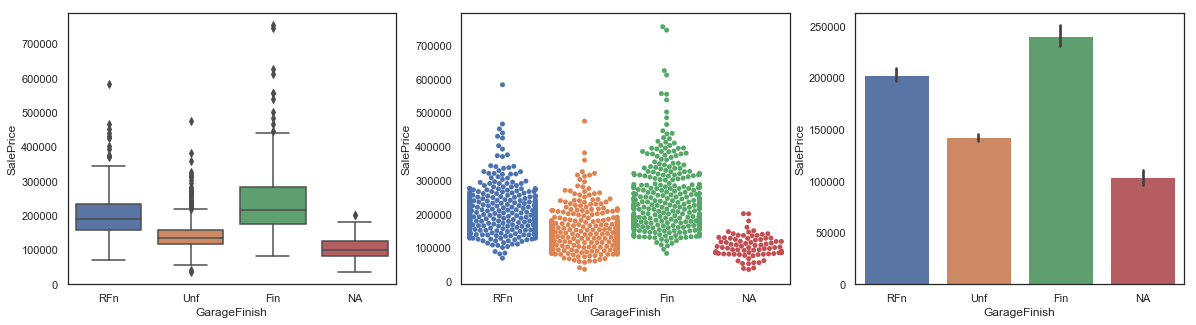

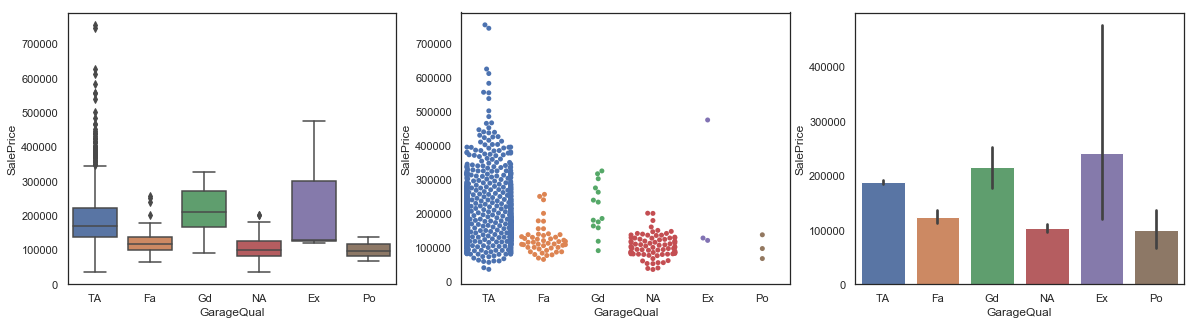

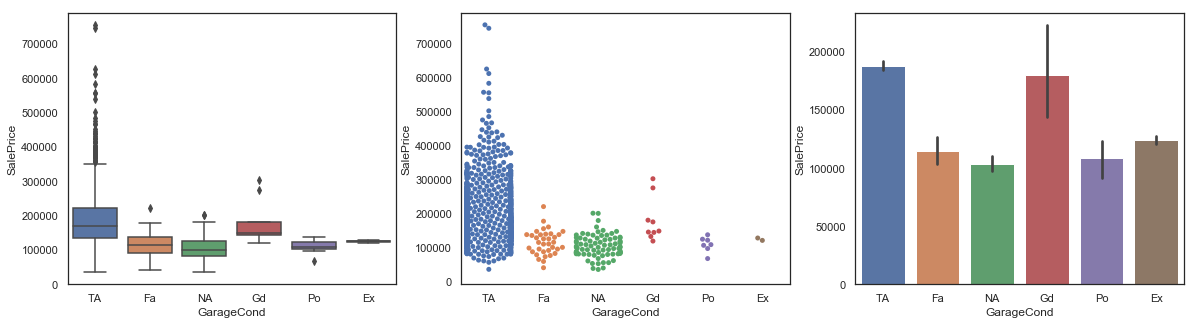

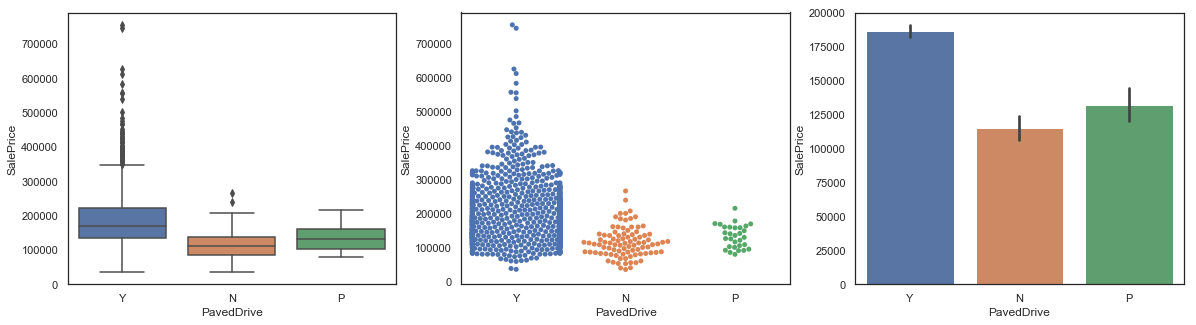

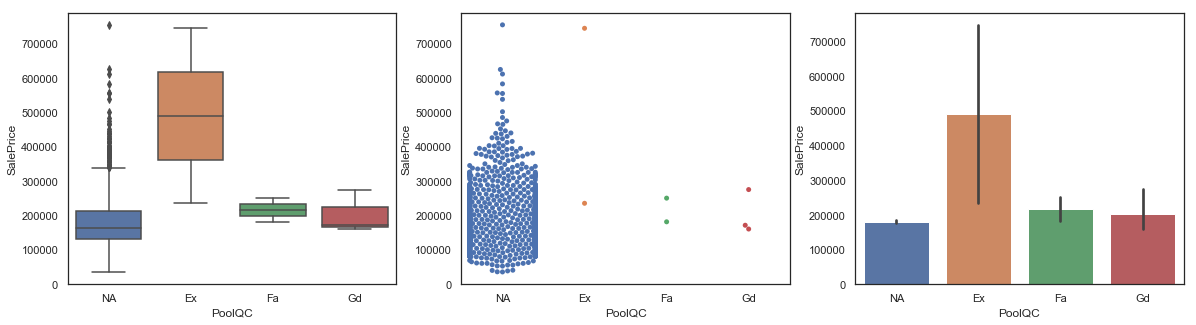

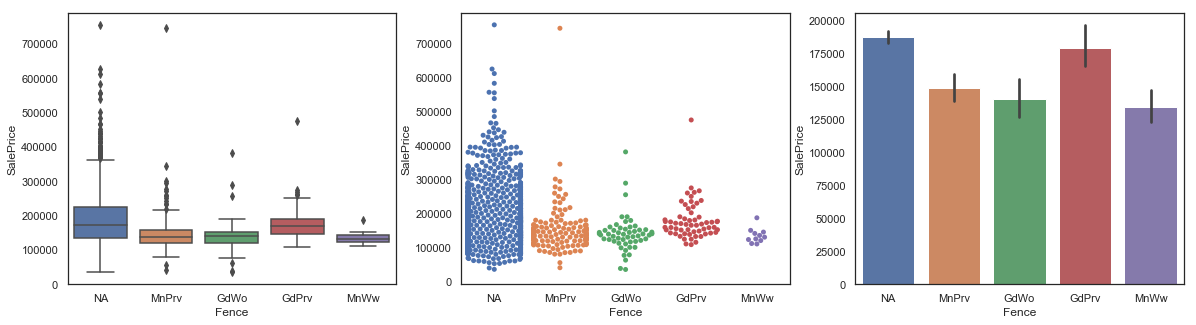

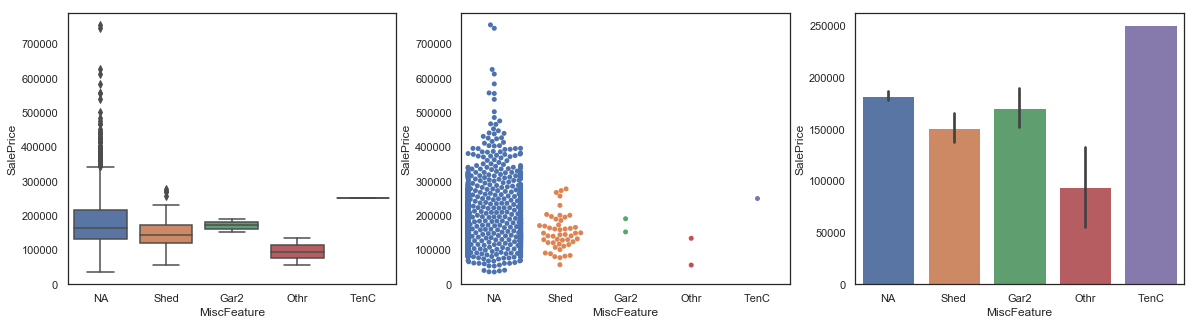

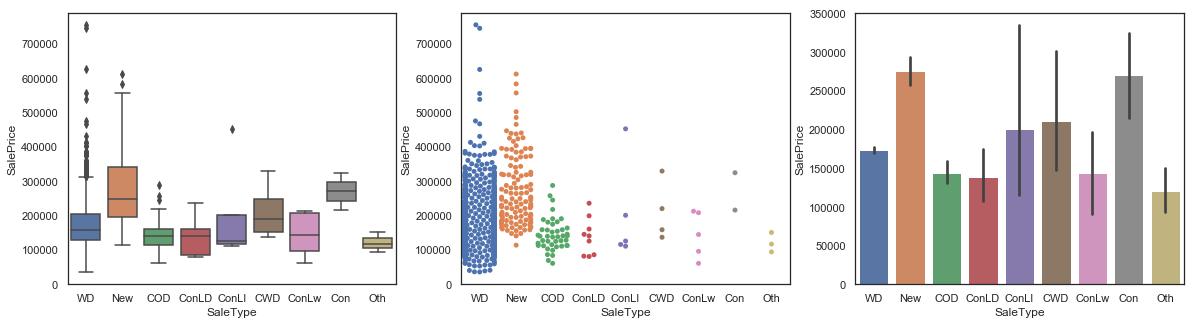

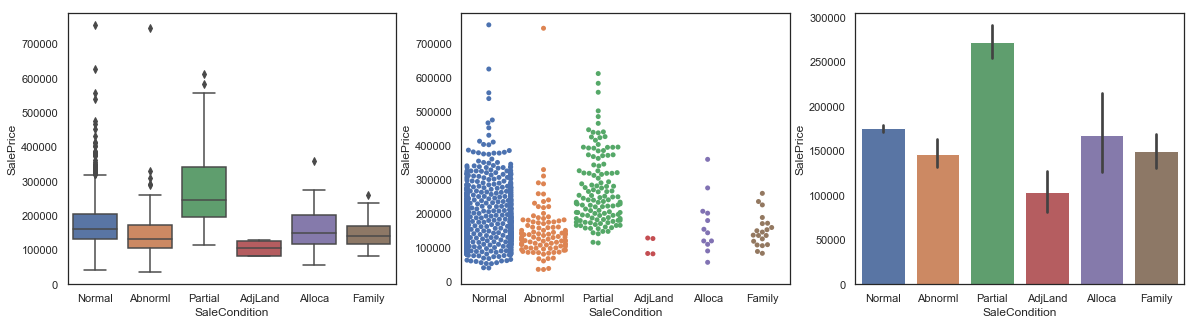

In [27]:
def cat_plot(data,column,ycolumn):
    plt.subplots(figsize =(20, 5))

    plt.subplot(1, 3, 1)
    sns.boxplot(x=column, y=ycolumn, data=data);

    plt.subplot(1, 3, 2)
    sns.swarmplot(x=column, y=ycolumn, data=data, size = 5);

    plt.subplot(1, 3, 3)
    sns.barplot(x=column, y=ycolumn, data=data)
    plt.show();
for var in categorical_features:
    cat_plot(train,column=var,ycolumn='SalePrice')

# Target Variable Understanding

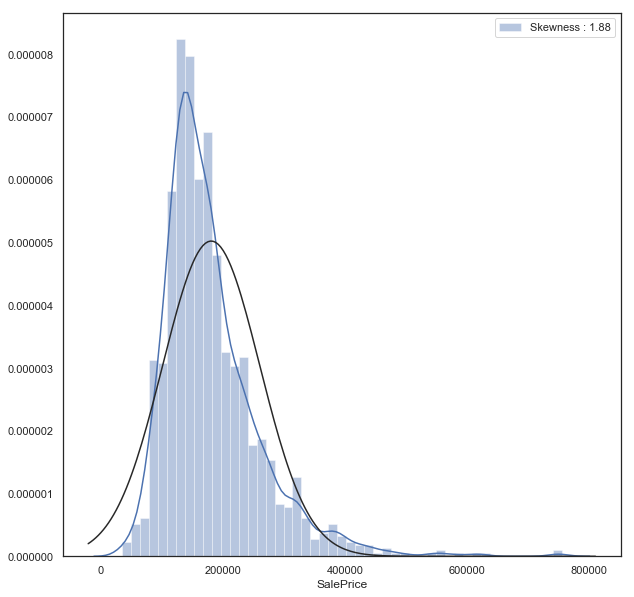

In [28]:
plt.subplots(figsize=(10, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

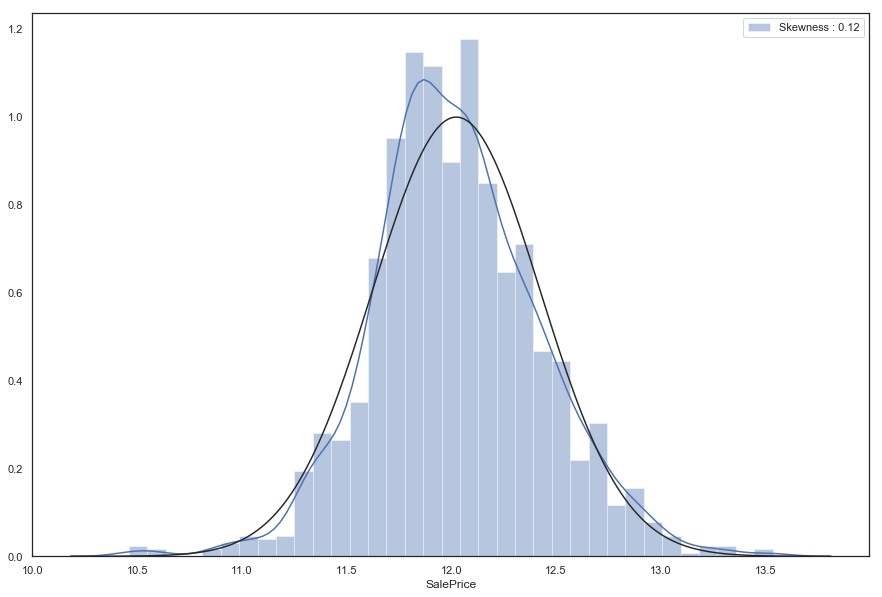

In [29]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

# Feature Engineering

In [ ]:
# Categorise the data before training

## Model Selection & Training

- Try different models and choose best 2-5 models
    - Use K-Fold cross-validation to validate which models are the best
- Typical ML models include kNN, SVM, linear/logistic regression, ensemble methods (RF, XGB), neural networks, etc.
- [Optional] Save experimental models to pickle file.

In [ ]:
# Creating pipeline for data
def model_data(data):
    
    # Dealing with the missing data for categorical variable
    for key,value in cat_deal.items():
    print(key,value)
    impute_type,flag_type = value.split(',')
    if flag_type == 'Yes':
        x,y = cat_impute(train[key],impute_type,flag_type)
        train[key] = x
        train['isna_'+key] =y
    else:
        train[key] =cat_impute(train[key],impute_type,flag_type)
    
    
    # Dealing with the missing data for continuous variable
    for key,value in num_deal.items():
    print(key,value)
    impute_type,flag_type = value.split(',')
    if flag_type == 'Yes':
        x,y = num_impute(train,key,impute_type,flag_type)
        train[key] = x
        train['isna_'+key] =y
    else:
        train[key] =num_impute(train,key,impute_type,flag_type)
    

## Model Tuning

- Tune the top chosen model(s) and tune hyperparameters
    - Ideally, use Bayes Optimization `BayesSearchCV` to optimally search for best hyperparameters for the model
        - `BayesSearchCV` is from `skopt` or `scikit-optimize` library (There are many different Bayesian Optimization implementations) 
- Below are some common search spaces for ensemble algorithms (which tend to have a lot of hyperparameters), specifically:
    - Random Forest (Variation of Bagging)
    - xgboost (Gradient Boosting)
    - lightgbm (Gradient Boosting)
        - https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
# Random Forest (Classificaton Example)

from sklearn.ensemble import RandomForestClassifier

rf_search_space = {
    'n_estimators': (100, 600),
    'max_depth': (1, 50),  
    'max_features': (1, n_features),
    'min_samples_leaf': (1, 50),  # integer valued parameter
    'min_samples_split': (2, 50),
}

rf_bayes_tuner = BayesSearchCV(
    estimator=RandomForestClassifier(oob_score=True, random_state=1, n_jobs=2),
    search_spaces=rf_search_space,
    n_iter=20,
    optimizer_kwargs={'base_estimator': 'RF'},
    scoring='neg_log_loss',
    n_jobs=5,
    verbose=0,
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    random_state=1
)


def status_print(result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(rf_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(rf_bayes_tuner.best_params_)
    print('Model #{}\nBest LogLoss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(rf_bayes_tuner.best_score_, 6),
        rf_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = rf_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

    
# Fit the model
result = rf_bayes_tuner.fit(X_train.values, Y_train.values, callback=status_print)

In [ ]:
# XGB (Classification Example)
import xgboost as xgb

xgb_search_space = { 
        # log-uniform: understand as search over p = exp(x) by varying x
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 100),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

xgb_bayes_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 3,
        objective = 'multi:softprob',
        eval_metric = 'mlogloss',
        silent=1,
        random_state=1
    ),
    search_spaces = xgb_search_space,    
    scoring = 'neg_log_loss',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    n_jobs = 6,
    n_iter = 20,   
    verbose = 0,
    refit = True,
    random_state = 1
)

def status_print(result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(xgb_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(xgb_bayes_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(xgb_bayes_tuner.best_score_, 8),
        xgb_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = xgb_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

# Fit the model
result = xgb_bayes_tuner.fit(X_train.values, Y_train.values, callback=status_print)

In [ ]:
# LGB (Regression Example)

import lightgbm as lgb

lgb_search_space  = {
    'max_depth': (3, 10),
    'num_leaves': (6, 30),
    'min_child_samples': (50, 200),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'n_estimators': (50, 500),
    'scale_pos_weight': (1e-6, 500, 'log-uniform'),
    'learning_rate': (0.01, 0.2, 'uniform')
}


lgb_bayes_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        n_jobs = 3,
        boosting_type="gbdt",
        objective = 'regression',
        silent=1,
        random_state=1
    ),
    search_spaces = lgb_search_space,    
    scoring = 'neg_mean_squared_error',
    cv = 3,
    n_jobs = 3,
    n_iter = 20,   
    verbose = 3,
    refit = True,
    random_state = 1
)

def status_print(result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(lgb_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(lgb_bayes_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(lgb_bayes_tuner.best_score_, 8),
        lgb_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = lgb_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

lgb_bayes_tuner.fit(housing_prepared, housing_labels, callback=status_print)

## Model Evaluation

- Final evaluation on the test set
- Calculation of confidence intervals using t-score or z-scores to give a range of values and confidence level